In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import warnings
warnings.filterwarnings("ignore")
import random
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
from torch.autograd import Function
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import json
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy import stats

In [ ]:
device = torch.device( "cuda" if torch.cuda.is_available() else"cpu")

In [ ]:
SEED = 42
def set_seed(seed = SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [ ]:
WINDOW_SIZE = 20
STEP_SIZE = 4
EMB_DIM = 300
HIDDEN_DIM = 128
OUTPUT_DIM = 2
N_LAYERS = 1
TRAIN_SIZE_S = 100000
TRAIN_SIZE_T = 10000
# VAL_ABNORMAL = 1000
# VAL_RATIO = 10
TIMES = 9
TRAIN_AB_SIZE_S = 0
ALPHA = 0.1
DROPOUT = 0.3
BATCH_SIZE = 1024
TEST_RATIO = 0.1
BIAS = True
TARGET = 'Thunderbird'
SOURCE = 'BGL'
EPS = 0.1

In [ ]:
df_target = pd.read_csv(f'/content/drive/MyDrive/P2/Data/{TARGET}.log_structured.csv')
print(f'Source dataset: {TARGET} dataset')
df_target.head()

Source dataset: Thunderbird dataset


,LineId,Label,Timestamp,Date,User,Month,Day,Time,Location,Component,PID,Content,EventId,EventTemplate,ParameterList
0,1,-,1131523501,2005.11.09,aadmin1,Nov,10,00:05:01,src@aadmin1,in.tftpd,14620.0,tftp: client does not accept options,c89a99ae,tftp: client does not accept options,[]
1,2,-,1131524071,2005.11.09,tbird-admin1,Nov,10,00:14:31,local@tbird-admin1,postfix/postdrop,10896.0,warning: unable to look up public/pickup: No s...,25be66dc,warning: unable to look up public/pickup: No s...,[]
2,3,-,1131524073,2005.11.09,tbird-admin1,Nov,10,00:14:33,local@tbird-admin1,postfix/postdrop,10900.0,warning: unable to look up public/pickup: No s...,25be66dc,warning: unable to look up public/pickup: No s...,[]
3,4,-,1131524106,2005.11.09,tbird-admin1,Nov,10,00:15:06,local@tbird-admin1,postfix/postdrop,10910.0,warning: unable to look up public/pickup: No s...,25be66dc,warning: unable to look up public/pickup: No s...,[]
4,5,-,1131524107,2005.11.09,tbird-admin1,Nov,10,00:15:07,local@tbird-admin1,postfix/postdrop,10913.0,warning: unable to look up public/pickup: No s...,25be66dc,warning: unable to look up public/pickup: No s...,[]


In [ ]:
df_source = pd.read_csv(f'/content/drive/MyDrive/P2/Data/{SOURCE}.log_structured.csv')
print(f'Target dataset: {SOURCE} dataset')
df_source.head()

Target dataset: BGL dataset


,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
1,2,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
2,3,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
3,4,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
4,5,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]


In [ ]:
test_sen = df_source.Content.iloc[1]
tokenizer = RegexpTokenizer(r'\w+')
result = [x.lower() for x in tokenizer.tokenize(test_sen)]
result

['instruction', 'cache', 'parity', 'error', 'corrected']

In [ ]:
def word2vec_train(lst, emb_dim = 150, seed = 42):
    '''
    train a word2vec mode
    args: lst(list of string): sentences
          emb_dim(int): word2vec embedding dimensions
          seed(int): seed for word2vec
    return: word2vec model
    '''
    tokenizer = RegexpTokenizer(r'\w+')
    sentences = []
    for i in lst:
        sentences.append([x.lower() for x in tokenizer.tokenize(str(i))])
    w2v = Word2Vec(sentences, size=emb_dim, min_count=1, seed=seed)
    return w2v

In [ ]:
set_seed()
W2V_T = 1
if W2V_T == 1:
    w2v = word2vec_train(np.concatenate((df_source.EventTemplate.values[:STEP_SIZE*TRAIN_SIZE_S],df_target.EventTemplate.values[:STEP_SIZE*TRAIN_SIZE_T])), emb_dim=EMB_DIM)
    w2v.save(f'/content/drive/MyDrive/P2/{SOURCE}-{TARGET}_w2v.bin')
else:
    w2v = Word2Vec.load(f'/content/drive/MyDrive/P2/{SOURCE}-{TARGET}_w2v.bin')

In [ ]:
set_seed()
def get_sentence_emb(sentence, w2v):
    '''
    get a sentence embedding vector
    *automatic initial random value to the new word
    args: sentence(string): sentence of log message
          w2v: word2vec model
    return: sen_emb(list of int): vector for the sentence
    '''
    tokenizer = RegexpTokenizer(r'\w+')
    lst = []
    tokens = [x.lower() for x in tokenizer.tokenize(str(sentence))]
    if tokens == []:
        tokens.append('EmptyParametersTokens')
    for i in range(len(tokens)):
        words = list(w2v.wv.vocab.keys())
        if tokens[i] in words:
            lst.append(w2v[tokens[i]])
        else:
            w2v.build_vocab([[tokens[i]]], update = True)
            w2v.train([tokens[i]], epochs=1, total_examples=len([tokens[i]]))
            lst.append(w2v[tokens[i]])
    drop = 1
    if len(np.array(lst).shape) >= 2:
        sen_emb = np.mean(np.array(lst), axis=0)
        if len(np.array(lst)) >= 5:
            drop = 0
    else:
        sen_emb = np.array(lst)
    return list(sen_emb), drop
# get_sentence_emb(df_BGL.EventTemplate.iloc[-1], w2v)

In [ ]:
set_seed()
PROC_EMB = 1
if PROC_EMB == 1:
    print(f'Processing source: {SOURCE} dataset')
    dic = {}
    lst_temp = list(set(df_source.EventTemplate.values))
    for i in tqdm(range(len(lst_temp))):
        (temp_val,drop) = get_sentence_emb([lst_temp[i]], w2v)
        dic[lst_temp[i]] = (temp_val, drop)
    lst_emb = []
    lst_drop = []
    for i in tqdm(range(len(df_source))):    
        lst_emb.append(dic[df_source.EventTemplate.loc[i]][0])
        lst_drop.append(dic[df_source.EventTemplate.loc[i]][1])
    df_source['Embedding'] = lst_emb
    df_source['drop'] = lst_drop
    # df_source.to_csv('/content/drive/MyDrive/P2/Source_Emb.csv')
    print(f'Processing target: {TARGET} dataset')
    dic = {}
    lst_temp = list(set(df_target.EventTemplate.values))
    for i in tqdm(range(len(lst_temp))):
        (temp_val,drop) = get_sentence_emb([lst_temp[i]], w2v)
        dic[lst_temp[i]] = (temp_val, drop)
    lst_emb = []
    lst_drop = []
    for i in tqdm(range(len(df_target))):
        lst_emb.append(dic[df_target.EventTemplate.loc[i]][0])
        lst_drop.append(dic[df_target.EventTemplate.loc[i]][1])
    df_target['Embedding'] = lst_emb
    df_target['drop'] = lst_drop
    # df_target.to_csv('/content/drive/MyDrive/P2/Target_Emb.csv')
else:
    df_source = pd.read_csv('/content/drive/MyDrive/P2/Source_Emb.csv', index_col=0)
    # 32GB Memory or larger:
    # lst = []
    # for i in tqdm(range(len(df_source))):
    #     lst.append(json.loads(df_source['Embedding'].loc[i]))
    # df_source['Embedding'] = lst
    # smaller than 32GB:
    for i in tqdm(range(len(df_source))):
        df_source.Embedding.loc[i] = json.loads(df_source.Embedding.loc[i])
    df_target = pd.read_csv('/content/drive/MyDrive/P2/Target_Emb.csv', index_col=0)
    # 32GB Memory or larger:    
    # lst = []
    # for i in tqdm(range(len(df_target))):
    #     lst.append(json.loads(df_target['Embedding'].loc[i]))
    # df_target['Embedding'] = lst
    # smaller than 32GB:
    for i in tqdm(range(len(df_target))):
        df_target.Embedding.loc[i] = json.loads(df_target.Embedding.loc[i])

  4%|▍         | 15/396 [00:00<00:02, 131.12it/s]

Processing source: BGL dataset


  5%|▍         | 39/806 [00:00<00:02, 306.67it/s]

Processing target: Thunderbird dataset


100%|██████████| 5000000/5000000 [03:52<00:00, 21504.37it/s]


In [ ]:
df_source = df_source.loc[df_source['drop'] == 0]
df_target = df_target.loc[df_target['drop'] == 0]

In [ ]:
def sliding_window(df, window_size = 20, step_size = 4, target = 0):
    df["Label"] = df["Label"].apply(lambda x: int(x != '-'))
    df = df[["Label", "Content", "Embedding"]]
    df['target'] = target
    log_size = df.shape[0]  
    label_data = df.iloc[:, 0]
    logkey_data = df.iloc[:, 1]
    emb_data = df.iloc[:, 2]  
    new_data = []
    index = 0
    while index <= log_size-window_size:
        new_data.append([
            max(label_data[index:index+window_size]),
            logkey_data[index:index+window_size].values,
            emb_data[index:index+window_size].values,
            target
        ])
        index += step_size
    return pd.DataFrame(new_data, columns=df.columns)

In [ ]:
set_seed()
# Get source data preprocessed
print(f'Start preprocessing for the source: {SOURCE} dataset')
window_df = sliding_window(df_source, WINDOW_SIZE, STEP_SIZE, 0)
#########
# Train #
#########
df_normal = window_df[window_df["Label"] == 0]
# shuffle normal data
df_normal = df_normal.sample(frac=1, random_state = 42).reset_index(drop=True)
normal_len = len(df_normal)
train_len = TRAIN_SIZE_S

train_normal_s = df_normal[:train_len]
print("Source training size {}".format(train_len))


###############
# Test Normal #
###############
test_normal_s = df_normal[train_len:]
print("Source test normal size {}".format(normal_len - train_len))

#################
# Test Abnormal #
#################
test_abnormal_s = window_df[window_df["Label"] == 1]
# val_abnormal_s = test_abnormal_s[:VAL_ABNORMAL]
# test_abnormal_s = test_abnormal_s[VAL_ABNORMAL:]
print('Source test abnormal size {}'.format(len(test_abnormal_s)))

print('------------------------------------------')
print(f'Start preprocessing for the target: {TARGET} dataset')
# Get target data preprocessed
window_df = sliding_window(df_target, WINDOW_SIZE, STEP_SIZE, 1)
#########
# Train #
#########
df_normal = window_df[window_df["Label"] == 0]
# shuffle normal data
df_normal = df_normal.sample(frac=1, random_state = 42).reset_index(drop=True)
normal_len = len(df_normal)
train_len = TRAIN_SIZE_T

train_normal_t = df_normal[:train_len]
print("Target training size {}".format(train_len))
temp = train_normal_t[:]
for _ in range(TIMES):
    train_normal_t = pd.concat([train_normal_t, temp])


###############
# Test Normal #
###############
test_normal_t = df_normal[train_len:]
print("Target test normal size {}".format(normal_len - train_len))

#################
# Test Abnormal #
#################
test_abnormal_t = window_df[window_df["Label"] == 1]
print('Target test abnormal size {}'.format(len(test_abnormal_t)))

Start preprocessing for the source: BGL dataset
Source training size 100000
Source test normal size 165583
Source test abnormal size 37450
------------------------------------------
Start preprocessing for the target: Thunderbird dataset
Target training size 10000
Target test normal size 555817
Target test abnormal size 368481


In [ ]:
class GRL(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [ ]:
class DA_LSTM(nn.Module):

    def __init__(self, emb_dim, hid_dim, output_dim, n_layers, dropout, bias):
        super().__init__()
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout, bidirectional=False, batch_first = True, bias=bias)

        self.discriminator = nn.Sequential(
            nn.Linear(hid_dim, 64),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, input, alpha):
        output, (hidden, cell) = self.rnn(input)
        y = GRL.apply(torch.mean(output, dim=1), alpha)
        y = self.discriminator(y)
        return torch.mean(output, dim = 1), y

In [ ]:
def get_center(emb, label = None):
    if label == None:
        return torch.mean(emb, 0)
    else:
        return 'Not defined'

In [ ]:
set_seed()
model = DA_LSTM(EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, BIAS).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-6)
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_mse = nn.MSELoss()
loss_cel = nn.CrossEntropyLoss()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 228,546 trainable parameters


In [ ]:
def train(model, iterator, optimizer, loss_mse, loss_cel, center, alpha):
    
    model.train()
    
    epoch_loss = 0

    for (i, batch) in enumerate(iterator):
        src = batch[0].to(device)
        domain_label = batch[1].to(device)
        labels = batch[2]
        optimizer.zero_grad()
        output, y_d = model(src, alpha)

        domain_label = domain_label.view(-1)
        center = center.to(device)

        mse = 0
        for (ind, val) in enumerate(output):
            if labels[ind] == 1:
                mse += (10 - loss_mse(val, center))
            else:
                mse += loss_mse(val, center)
        cel = loss_cel(y_d, domain_label.to(dtype = torch.long))
        loss = mse*10e4 + cel
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        center.cpu()
        src.cpu()
        domain_label.cpu()
        output.cpu()
        y_d.cpu()

    return epoch_loss / len(iterator)

In [ ]:
def get_dist(ts, center):
    ts = ts.cpu().detach().numpy()
    center = center.cpu().numpy()
    temp = []
    for i in ts:
        temp.append(np.linalg.norm(i-center))
    return temp

In [ ]:
def evaluate(model, iterator, loss_mse, loss_cel, center, epoch, alpha, eps):
    
    model.eval()
    
    epoch_loss = 0
    
    lst_dist = []

    lst_mse = []
    lst_cel = []

    with torch.no_grad():
        for (i, batch) in enumerate(iterator):
            src = batch[0].to(device)
            domain_label =  batch[1].to(device)
            labels = batch[2]
            output, y_d = model(src, alpha)
            if i == 0:
                lst_emb = output
            else:
                lst_emb = torch.cat((lst_emb, output), dim = 0)

            domain_label = domain_label.view(-1)

            center = center.to(device)

            mse = 0
            for (ind, val) in enumerate(output):
                if labels[ind] == 1:
                    mse += (10 - loss_mse(val, center))
                else:
                    mse += loss_mse(val, center)

            cel = loss_cel(y_d, domain_label.to(dtype = torch.long))

            lst_mse.append(mse.detach().cpu().numpy())
            lst_cel.append(cel.detach().cpu().numpy())

            loss = mse*10e4 + cel
            
            epoch_loss += loss.item()
            
            lst_dist.extend(get_dist(output, center))

            src.cpu()
            domain_label.cpu()
            lst_emb.cpu()
            output.cpu()
            y_d.cpu()
    
    if epoch < 10:
        center = get_center(lst_emb)
        print('get center:',center)
        center[(abs(center) < eps) & (center < 0)] = -eps
        center[(abs(center) < eps) & (center > 0)] = eps  
        print('new center', center)      
        
    print('\nmse:', np.mean(np.array(lst_mse)))
    print('cel:', np.mean(np.array(lst_cel)))
    return epoch_loss / len(iterator), center, lst_dist

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
class LogDataset(Dataset):
    def __init__(self, features, domain_labels, labels):
        super().__init__()
        self.features = features
        self.domain_labels = domain_labels
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.features[idx], self.domain_labels[idx], self.labels[idx])

In [ ]:
def get_iter(X, y_d, y, shuffle = True):
    dataset = LogDataset(X, y_d, y)
    if shuffle == True:
        iter = DataLoader(dataset, BATCH_SIZE, shuffle = True, worker_init_fn=np.random.seed(42))
    else:
        iter = DataLoader(dataset, BATCH_SIZE)
    return iter

In [ ]:
set_seed()
X = list(train_normal_s.Embedding.values)
X.extend(list(train_normal_t.Embedding.values))
X.extend(list(test_abnormal_s.Embedding.values[:TRAIN_AB_SIZE_S]))
X_new = []
for i in tqdm(X):
    temp = []
    for j in i:
        temp.extend(j)
    X_new.append(np.array(temp).reshape(WINDOW_SIZE, EMB_DIM))
y_d = list(train_normal_s.target.values)
y_d.extend(list(train_normal_t.target.values))
y_d.extend(list(test_abnormal_s.target.values[:TRAIN_AB_SIZE_S]))
y = list(train_normal_s.Label.values)
y.extend(list(train_normal_t.Label.values))
y.extend(list(test_abnormal_s.Label.values[:TRAIN_AB_SIZE_S]))
X_train, X_eval, y_d_train, y_d_eval, y_train, y_eval = train_test_split(X_new, y_d, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train,requires_grad=False)
X_eval = torch.tensor(X_eval,requires_grad=False)
y_d_train = torch.tensor(y_d_train).reshape(-1, 1).long()
y_d_eval = torch.tensor(y_d_eval).reshape(-1, 1).long()
y_train = torch.tensor(y_train).reshape(-1, 1).long()
y_eval = torch.tensor(y_eval).reshape(-1, 1).long()
train_iter = get_iter(X_train, y_d_train, y_train)
eval_iter = get_iter(X_eval, y_d_eval, y_eval)
del X_new
del y_d
del y

100%|██████████| 200000/200000 [01:45<00:00, 1897.28it/s]


In [ ]:
set_seed()
TRAINING = 1
if TRAINING == 1:
    N_EPOCHS = 300

    best_eval_loss = float('inf')

    for epoch in tqdm(range(N_EPOCHS)):
        
        # ALPHA = 2. / (1. + np.exp(-10 * epoch/(N_EPOCHS-1))) - 1

        if epoch == 0:
            center = torch.Tensor([0.0 for _ in range(HIDDEN_DIM)])
        if epoch > 9:
            center = fixed_center
        start_time = time.time()
        train_loss= train(model, train_iter, optimizer, loss_mse, loss_cel, center, ALPHA)        

        eval_loss, center, _ = evaluate(model, eval_iter, loss_mse, loss_cel, center, epoch, ALPHA, EPS)
        
        if epoch == 9:
            fixed_center = center

        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if eval_loss < best_eval_loss and epoch>=9:
            best_eval_loss = eval_loss
            torch.save(model.state_dict(), f'/content/drive/MyDrive/P2/{SOURCE}-{TARGET}.pt')

            pd.DataFrame(fixed_center.cpu().numpy()).to_csv(f'/content/drive/MyDrive/P2/{SOURCE}-{TARGET}_center.csv')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.10f}')
        print(f'\t Val. Loss: {eval_loss:.10f}')

  0%|          | 1/300 [00:31<2:35:44, 31.25s/it]

get center: tensor([ 8.1404e-05, -8.4833e-05, -6.3794e-05, -1.8432e-04,  8.9928e-05,
         8.9932e-07,  1.0540e-04, -1.5376e-04, -2.3630e-04, -2.4506e-04,
         2.5327e-04,  4.1712e-04, -2.7695e-04,  8.7433e-05,  1.9113e-04,
         1.6559e-04,  1.7448e-04,  3.4793e-04, -1.3475e-04,  1.5641e-04,
        -1.5667e-04,  1.3329e-04,  2.4580e-05,  7.3621e-05,  1.1677e-06,
         8.6089e-05,  2.3004e-06,  5.9809e-04, -3.0829e-04, -1.6112e-04,
         3.1790e-04, -4.3057e-07,  9.4737e-05,  2.2040e-04,  2.7927e-04,
         2.1287e-04, -9.2816e-05,  1.6686e-04,  7.2009e-05,  1.0431e-04,
        -2.2646e-04,  1.2541e-04, -1.1157e-04, -1.7749e-04, -1.1497e-04,
         5.2479e-05, -1.7107e-04, -9.9840e-06, -2.3007e-04, -3.8304e-04,
        -1.4393e-04,  2.0943e-04, -9.5098e-06,  2.0551e-04, -1.1952e-04,
        -3.1879e-04,  5.2436e-05,  1.6179e-04, -1.2261e-05,  1.6216e-04,
         4.4662e-04, -4.8911e-05, -4.8206e-04,  6.5923e-04, -2.3431e-04,
         1.1761e-04,  2.4836e-04,  9.90

  1%|          | 2/300 [01:02<2:35:44, 31.36s/it]

get center: tensor([ 0.0999, -0.0999, -0.1000, -0.1000,  0.1000,  0.0997,  0.1000, -0.0999,
        -0.0997, -0.0997,  0.0998,  0.0999, -0.1000,  0.1001,  0.1000,  0.1000,
         0.0998,  0.0999, -0.1000,  0.0999, -0.1000,  0.0998,  0.0999,  0.0999,
         0.0999,  0.1000,  0.0999,  0.0997, -0.1000, -0.0999,  0.0999, -0.0999,
         0.1000,  0.1000,  0.0999,  0.0999, -0.1000,  0.1000,  0.0998,  0.1000,
        -0.1000,  0.0996, -0.0998, -0.0999, -0.0997,  0.1001, -0.1000, -0.1000,
        -0.1000, -0.0999, -0.0999,  0.0999, -0.1000,  0.0998, -0.0999, -0.0999,
         0.1000,  0.0999, -0.1000,  0.0999,  0.0999, -0.0998, -0.0999,  0.0999,
        -0.1001,  0.0998,  0.0999,  0.1000, -0.0999,  0.0999,  0.0999,  0.1000,
        -0.0999,  0.0998, -0.0999,  0.0999,  0.0998, -0.0999, -0.1000,  0.1000,
        -0.1000, -0.0999, -0.0999, -0.1000, -0.0998,  0.0999,  0.1000, -0.0998,
         0.1000, -0.1000,  0.0998, -0.0999,  0.0997,  0.1000, -0.1000, -0.1000,
         0.1000,  0.0999, -0

  1%|          | 3/300 [01:33<2:34:40, 31.25s/it]

get center: tensor([ 0.1001, -0.1000, -0.1001, -0.1001,  0.1000,  0.0999,  0.1000, -0.1001,
        -0.0999, -0.1000,  0.0999,  0.1000, -0.1001,  0.1001,  0.1000,  0.1000,
         0.1000,  0.1001, -0.1000,  0.0999, -0.1000,  0.1000,  0.1001,  0.1001,
         0.1000,  0.1001,  0.1001,  0.1000, -0.1000, -0.1000,  0.1000, -0.1000,
         0.0999,  0.1001,  0.0999,  0.0999, -0.1000,  0.1000,  0.1000,  0.1001,
        -0.1000,  0.1000, -0.1001, -0.1000, -0.1000,  0.1001, -0.1000, -0.1001,
        -0.1000, -0.1001, -0.1001,  0.1000, -0.1001,  0.1000, -0.1000, -0.1000,
         0.1001,  0.1000, -0.1001,  0.1000,  0.1000, -0.1000, -0.1000,  0.1000,
        -0.1001,  0.1000,  0.1000,  0.1001, -0.1000,  0.1001,  0.1001,  0.1001,
        -0.1000,  0.1000, -0.1000,  0.1001,  0.0999, -0.1000, -0.1000,  0.1001,
        -0.1001, -0.1000, -0.1000, -0.1001, -0.1000,  0.1000,  0.1000, -0.1000,
         0.1000, -0.1001,  0.1000, -0.1001,  0.1000,  0.1001, -0.1000, -0.1000,
         0.1000,  0.1000, -0

  1%|▏         | 4/300 [02:05<2:35:23, 31.50s/it]

get center: tensor([ 0.1000, -0.1000, -0.1001, -0.1001,  0.1001,  0.0999,  0.1001, -0.1001,
        -0.0999, -0.0999,  0.1000,  0.1000, -0.1000,  0.1002,  0.1000,  0.1000,
         0.1000,  0.1001, -0.1001,  0.1001, -0.1000,  0.1000,  0.1000,  0.1000,
         0.1000,  0.1001,  0.1001,  0.1000, -0.1000, -0.1000,  0.1000, -0.1001,
         0.0999,  0.1001,  0.0999,  0.1000, -0.1001,  0.1000,  0.1000,  0.1001,
        -0.1000,  0.1000, -0.1000, -0.1000, -0.0999,  0.1001, -0.1001, -0.1001,
        -0.1000, -0.1000, -0.1000,  0.0999, -0.1000,  0.1000, -0.1000, -0.1000,
         0.1001,  0.1000, -0.1001,  0.1000,  0.1000, -0.1000, -0.1000,  0.1000,
        -0.1001,  0.1000,  0.1000,  0.1001, -0.1000,  0.1000,  0.1000,  0.1000,
        -0.1000,  0.1000, -0.0999,  0.1001,  0.1000, -0.1000, -0.1000,  0.1000,
        -0.1001, -0.1000, -0.0999, -0.1001, -0.1001,  0.1000,  0.1000, -0.1000,
         0.1000, -0.1001,  0.1000, -0.1001,  0.1000,  0.1001, -0.1000, -0.1000,
         0.1000,  0.1000, -0

  2%|▏         | 5/300 [02:37<2:35:22, 31.60s/it]

get center: tensor([ 0.1000, -0.1000, -0.1001, -0.1000,  0.1001,  0.1000,  0.1001, -0.1001,
        -0.0999, -0.1000,  0.1000,  0.0999, -0.1000,  0.1002,  0.1000,  0.1000,
         0.1000,  0.1000, -0.1001,  0.1000, -0.1000,  0.1000,  0.1000,  0.0999,
         0.1000,  0.1001,  0.1001,  0.0999, -0.1000, -0.1000,  0.1000, -0.1000,
         0.1000,  0.1001,  0.1000,  0.1000, -0.1001,  0.1000,  0.1000,  0.1000,
        -0.1000,  0.0999, -0.1000, -0.1000, -0.1000,  0.1001, -0.1001, -0.1001,
        -0.1000, -0.1000, -0.1000,  0.0999, -0.1000,  0.1000, -0.1000, -0.1000,
         0.1001,  0.1000, -0.1001,  0.1000,  0.1001, -0.0999, -0.1000,  0.1000,
        -0.1001,  0.1000,  0.1000,  0.1001, -0.1000,  0.1000,  0.1001,  0.1000,
        -0.0999,  0.1000, -0.1000,  0.1001,  0.1000, -0.1000, -0.0999,  0.1000,
        -0.1001, -0.1001, -0.0999, -0.1001, -0.1000,  0.1000,  0.1001, -0.1000,
         0.1000, -0.1001,  0.1000, -0.1000,  0.0999,  0.1000, -0.1000, -0.1000,
         0.1000,  0.1000, -0

  2%|▏         | 6/300 [03:09<2:35:31, 31.74s/it]

get center: tensor([ 0.1000, -0.1001, -0.1001, -0.1001,  0.1000,  0.1001,  0.1001, -0.1001,
        -0.1001, -0.1001,  0.1001,  0.1000, -0.1000,  0.1003,  0.1001,  0.1000,
         0.1001,  0.1000, -0.1001,  0.1001, -0.1000,  0.1001,  0.1000,  0.1000,
         0.1000,  0.1001,  0.1001,  0.1000, -0.1001, -0.1000,  0.1000, -0.1001,
         0.1000,  0.1001,  0.1000,  0.1000, -0.1001,  0.1000,  0.1000,  0.1000,
        -0.1001,  0.1001, -0.1001, -0.1001, -0.1000,  0.1001, -0.1001, -0.1001,
        -0.1000, -0.1000, -0.1000,  0.1000, -0.1000,  0.1000, -0.1000, -0.1000,
         0.1001,  0.1000, -0.1002,  0.1000,  0.1001, -0.0999, -0.1001,  0.1001,
        -0.1002,  0.1001,  0.1001,  0.1002, -0.1001,  0.1000,  0.1001,  0.1001,
        -0.1001,  0.1001, -0.1000,  0.1002,  0.1000, -0.1000, -0.1000,  0.1001,
        -0.1001, -0.1001, -0.1001, -0.1002, -0.1001,  0.1001,  0.1001, -0.1000,
         0.1000, -0.1001,  0.1001, -0.1001,  0.1000,  0.1001, -0.1000, -0.1000,
         0.1001,  0.1001, -0

  2%|▏         | 7/300 [03:41<2:35:02, 31.75s/it]

get center: tensor([ 0.1000, -0.1000, -0.1001, -0.1001,  0.1000,  0.1000,  0.1001, -0.1001,
        -0.1000, -0.1000,  0.1001,  0.0999, -0.1000,  0.1003,  0.1001,  0.1000,
         0.1001,  0.1001, -0.1001,  0.1000, -0.1000,  0.1000,  0.1001,  0.1000,
         0.0999,  0.1001,  0.1001,  0.1000, -0.1000, -0.1000,  0.1000, -0.1001,
         0.0999,  0.1001,  0.1000,  0.1000, -0.1001,  0.1000,  0.1000,  0.1001,
        -0.1001,  0.1000, -0.1000, -0.1001, -0.1000,  0.1001, -0.1001, -0.1001,
        -0.1001, -0.1000, -0.1001,  0.1000, -0.1001,  0.0999, -0.1000, -0.1001,
         0.1001,  0.1000, -0.1001,  0.1000,  0.1001, -0.1001, -0.1000,  0.1001,
        -0.1001,  0.1000,  0.1000,  0.1001, -0.1000,  0.1000,  0.1001,  0.1001,
        -0.1000,  0.1000, -0.1000,  0.1002,  0.1000, -0.1000, -0.1000,  0.1001,
        -0.1000, -0.1000, -0.1000, -0.1002, -0.1001,  0.1001,  0.1002, -0.1001,
         0.1000, -0.1001,  0.1000, -0.1001,  0.1000,  0.1001, -0.1000, -0.1000,
         0.1000,  0.1000, -0

  3%|▎         | 8/300 [04:13<2:34:08, 31.67s/it]

get center: tensor([ 0.1001, -0.1000, -0.1001, -0.1001,  0.1000,  0.1000,  0.1001, -0.1001,
        -0.1000, -0.1000,  0.1001,  0.1000, -0.1000,  0.1003,  0.1001,  0.1000,
         0.1001,  0.1001, -0.1000,  0.1000, -0.1000,  0.1000,  0.1001,  0.1000,
         0.1000,  0.1001,  0.1001,  0.0999, -0.1000, -0.1000,  0.1000, -0.1000,
         0.1000,  0.1001,  0.1000,  0.1000, -0.1001,  0.1000,  0.1000,  0.1000,
        -0.1001,  0.1000, -0.1000, -0.1000, -0.1000,  0.1001, -0.1001, -0.1001,
        -0.1000, -0.1000, -0.1001,  0.1000, -0.1000,  0.1000, -0.1000, -0.1001,
         0.1001,  0.1000, -0.1001,  0.1000,  0.1001, -0.1001, -0.1000,  0.1001,
        -0.1001,  0.1000,  0.1000,  0.1001, -0.1000,  0.1000,  0.1001,  0.1001,
        -0.1000,  0.1000, -0.1000,  0.1002,  0.1000, -0.1000, -0.1000,  0.1001,
        -0.1000, -0.1000, -0.1000, -0.1002, -0.1001,  0.1001,  0.1002, -0.1001,
         0.1000, -0.1002,  0.1001, -0.1001,  0.1000,  0.1001, -0.1000, -0.1001,
         0.1000,  0.1001, -0

  3%|▎         | 9/300 [04:43<2:32:21, 31.41s/it]

get center: tensor([ 0.1001, -0.1000, -0.1001, -0.1002,  0.1000,  0.0999,  0.1002, -0.1001,
        -0.0999, -0.0999,  0.1000,  0.1000, -0.1000,  0.1003,  0.1000,  0.1000,
         0.1000,  0.1001, -0.1000,  0.1000, -0.1000,  0.1000,  0.1001,  0.1000,
         0.1000,  0.1001,  0.1001,  0.1000, -0.1000, -0.1000,  0.1000, -0.1000,
         0.1000,  0.1002,  0.1000,  0.1000, -0.1001,  0.1000,  0.1000,  0.1000,
        -0.1001,  0.0999, -0.1000, -0.1000, -0.0999,  0.1000, -0.1001, -0.1001,
        -0.1001, -0.0999, -0.1001,  0.1000, -0.1000,  0.1000, -0.1000, -0.1001,
         0.1001,  0.0999, -0.1001,  0.0999,  0.1000, -0.1001, -0.1000,  0.1000,
        -0.1001,  0.1000,  0.1000,  0.1002, -0.0999,  0.1000,  0.1001,  0.1000,
        -0.1000,  0.1000, -0.0999,  0.1002,  0.1000, -0.1000, -0.1000,  0.1001,
        -0.1000, -0.1000, -0.1000, -0.1002, -0.1001,  0.1001,  0.1001, -0.1001,
         0.1000, -0.1002,  0.1001, -0.1001,  0.1000,  0.1001, -0.1000, -0.1001,
         0.1000,  0.1000, -0

  3%|▎         | 10/300 [05:15<2:32:12, 31.49s/it]

get center: tensor([ 0.1001, -0.1000, -0.1000, -0.1002,  0.1001,  0.0999,  0.1001, -0.1001,
        -0.1000, -0.1000,  0.1000,  0.1000, -0.1000,  0.1003,  0.1000,  0.1000,
         0.1000,  0.1001, -0.1000,  0.1000, -0.1000,  0.1000,  0.1000,  0.1000,
         0.1000,  0.1000,  0.1001,  0.1000, -0.1000, -0.1001,  0.1000, -0.1001,
         0.1000,  0.1002,  0.1000,  0.1000, -0.1001,  0.1000,  0.1000,  0.0999,
        -0.1001,  0.1000, -0.1000, -0.1001, -0.1000,  0.1001, -0.1001, -0.1001,
        -0.1001, -0.1000, -0.1001,  0.1000, -0.1000,  0.1000, -0.1000, -0.1001,
         0.1001,  0.1001, -0.1001,  0.0999,  0.1000, -0.1000, -0.1000,  0.1000,
        -0.1001,  0.1000,  0.1000,  0.1002, -0.1000,  0.1000,  0.1001,  0.1000,
        -0.1000,  0.1000, -0.0999,  0.1001,  0.1000, -0.1000, -0.1000,  0.1000,
        -0.1000, -0.1000, -0.1000, -0.1002, -0.1000,  0.1001,  0.1002, -0.1001,
         0.1000, -0.1002,  0.1001, -0.1001,  0.1000,  0.1001, -0.1001, -0.1001,
         0.1000,  0.1000, -0

  4%|▎         | 11/300 [05:46<2:30:57, 31.34s/it]


mse: 0.0012423155
cel: 0.69311905
Epoch: 11 | Time: 0m 30s
	Train Loss: 137.7160531184
	 Val. Loss: 124.9246662259


  4%|▍         | 12/300 [06:17<2:30:33, 31.36s/it]


mse: 0.0011044998
cel: 0.6929895
Epoch: 12 | Time: 0m 31s
	Train Loss: 122.2173130619
	 Val. Loss: 111.1429612160


  4%|▍         | 13/300 [06:49<2:29:41, 31.30s/it]


mse: 0.0009899032
cel: 0.6928522
Epoch: 13 | Time: 0m 31s
	Train Loss: 109.1566489153
	 Val. Loss: 99.6831732869


  5%|▍         | 14/300 [07:19<2:28:30, 31.15s/it]


mse: 0.0008939352
cel: 0.6929692
Epoch: 14 | Time: 0m 30s
	Train Loss: 98.0798732855
	 Val. Loss: 90.0864921808


  5%|▌         | 15/300 [07:50<2:27:39, 31.09s/it]


mse: 0.0008098739
cel: 0.69310963
Epoch: 15 | Time: 0m 30s
	Train Loss: 88.7910952477
	 Val. Loss: 81.6805037618


  5%|▌         | 16/300 [08:22<2:27:46, 31.22s/it]


mse: 0.00073657825
cel: 0.6930278
Epoch: 16 | Time: 0m 31s
	Train Loss: 80.6326168814
	 Val. Loss: 74.3508592725


  6%|▌         | 17/300 [08:53<2:27:25, 31.26s/it]


mse: 0.00067307276
cel: 0.6932539
Epoch: 17 | Time: 0m 31s
	Train Loss: 73.5840107985
	 Val. Loss: 68.0005277395


  6%|▌         | 18/300 [09:25<2:27:02, 31.29s/it]


mse: 0.0006200575
cel: 0.6933176
Epoch: 18 | Time: 0m 31s
	Train Loss: 67.4821958603
	 Val. Loss: 62.6990700603


  6%|▋         | 19/300 [09:56<2:26:06, 31.20s/it]


mse: 0.0005708003
cel: 0.6939106
Epoch: 19 | Time: 0m 30s
	Train Loss: 62.2344457906
	 Val. Loss: 57.7739382863


  7%|▋         | 20/300 [10:27<2:25:44, 31.23s/it]


mse: 0.0005288358
cel: 0.69299996
Epoch: 20 | Time: 0m 31s
	Train Loss: 57.4642221730
	 Val. Loss: 53.5765816092


  7%|▋         | 21/300 [10:58<2:25:04, 31.20s/it]


mse: 0.0004919594
cel: 0.6930602
Epoch: 21 | Time: 0m 31s
	Train Loss: 53.3647603806
	 Val. Loss: 49.8890005469


  7%|▋         | 22/300 [11:29<2:24:17, 31.14s/it]


mse: 0.00045972603
cel: 0.69369775
Epoch: 22 | Time: 0m 30s
	Train Loss: 49.7497482118
	 Val. Loss: 46.6663006723


  8%|▊         | 23/300 [12:01<2:24:12, 31.24s/it]


mse: 0.00043012513
cel: 0.6931418
Epoch: 23 | Time: 0m 31s
	Train Loss: 46.4764469596
	 Val. Loss: 43.7056557894


  8%|▊         | 24/300 [12:32<2:23:48, 31.26s/it]


mse: 0.00040561537
cel: 0.6931114
Epoch: 24 | Time: 0m 31s
	Train Loss: 43.5063196960
	 Val. Loss: 41.2546519160


  8%|▊         | 25/300 [13:03<2:23:19, 31.27s/it]


mse: 0.00037785232
cel: 0.69336283
Epoch: 25 | Time: 0m 31s
	Train Loss: 40.8005605291
	 Val. Loss: 38.4785957873


  9%|▊         | 26/300 [13:34<2:22:33, 31.22s/it]


mse: 0.00036611207
cel: 0.6931219
Epoch: 26 | Time: 0m 31s
	Train Loss: 38.4498569586
	 Val. Loss: 37.3043308735


  9%|▉         | 27/300 [14:05<2:21:57, 31.20s/it]


mse: 0.0003379002
cel: 0.6931713
Epoch: 27 | Time: 0m 31s
	Train Loss: 36.3313634229
	 Val. Loss: 34.4831910610


  9%|▉         | 28/300 [14:37<2:21:37, 31.24s/it]


mse: 0.00032418655
cel: 0.69320464
Epoch: 28 | Time: 0m 31s
	Train Loss: 34.2812734774
	 Val. Loss: 33.1118607044


 10%|▉         | 29/300 [15:08<2:21:41, 31.37s/it]


mse: 0.00030341098
cel: 0.69316036
Epoch: 29 | Time: 0m 31s
	Train Loss: 32.4576483684
	 Val. Loss: 31.0342567801


 10%|█         | 30/300 [15:39<2:20:45, 31.28s/it]


mse: 0.00029884028
cel: 0.6934706
Epoch: 30 | Time: 0m 31s
	Train Loss: 30.7583887015
	 Val. Loss: 30.5775011539


 10%|█         | 31/300 [16:11<2:20:12, 31.27s/it]


mse: 0.0002748885
cel: 0.6931144
Epoch: 31 | Time: 0m 31s
	Train Loss: 29.3160201212
	 Val. Loss: 28.1819648504


 11%|█         | 32/300 [16:43<2:20:46, 31.52s/it]


mse: 0.00026967685
cel: 0.693138
Epoch: 32 | Time: 0m 32s
	Train Loss: 27.9213050915
	 Val. Loss: 27.6608219504


 11%|█         | 33/300 [17:15<2:20:54, 31.66s/it]


mse: 0.00025789413
cel: 0.69316816
Epoch: 33 | Time: 0m 31s
	Train Loss: 26.6874764740
	 Val. Loss: 26.4825818360


 11%|█▏        | 34/300 [17:47<2:20:42, 31.74s/it]


mse: 0.00025975294
cel: 0.6931966
Epoch: 34 | Time: 0m 31s
	Train Loss: 25.6214943904
	 Val. Loss: 26.6684902549


 12%|█▏        | 35/300 [18:19<2:20:50, 31.89s/it]


mse: 0.00023910598
cel: 0.69320935
Epoch: 35 | Time: 0m 32s
	Train Loss: 25.2721515765
	 Val. Loss: 24.6038071156


 12%|█▏        | 36/300 [18:50<2:19:39, 31.74s/it]


mse: 0.00023351234
cel: 0.69314307
Epoch: 36 | Time: 0m 31s
	Train Loss: 24.0569924215
	 Val. Loss: 24.0443797112


 12%|█▏        | 37/300 [19:21<2:18:08, 31.51s/it]


mse: 0.00034645997
cel: 0.69315076
Epoch: 37 | Time: 0m 30s
	Train Loss: 24.8209376700
	 Val. Loss: 35.3391507387


 13%|█▎        | 38/300 [19:53<2:17:39, 31.52s/it]


mse: 0.00021230984
cel: 0.6931488
Epoch: 38 | Time: 0m 31s
	Train Loss: 32.2544061515
	 Val. Loss: 21.9241309285


 13%|█▎        | 39/300 [20:24<2:17:06, 31.52s/it]


mse: 0.00026376365
cel: 0.6931385
Epoch: 39 | Time: 0m 31s
	Train Loss: 21.3243646075
	 Val. Loss: 27.0695031524


 13%|█▎        | 40/300 [20:56<2:16:20, 31.46s/it]


mse: 0.00019481189
cel: 0.6931449
Epoch: 40 | Time: 0m 31s
	Train Loss: 24.2907037006
	 Val. Loss: 20.1743334770


 14%|█▎        | 41/300 [21:27<2:15:20, 31.35s/it]


mse: 0.00033891894
cel: 0.69317037
Epoch: 41 | Time: 0m 31s
	Train Loss: 21.6332033060
	 Val. Loss: 34.5850635231


 14%|█▍        | 42/300 [21:58<2:14:58, 31.39s/it]


mse: 0.00017584846
cel: 0.69325715
Epoch: 42 | Time: 0m 31s
	Train Loss: 36.8261460559
	 Val. Loss: 18.2781031668


 14%|█▍        | 43/300 [22:29<2:13:51, 31.25s/it]


mse: 0.00021268683
cel: 0.6931771
Epoch: 43 | Time: 0m 30s
	Train Loss: 20.3006363887
	 Val. Loss: 21.9618618578


 15%|█▍        | 44/300 [23:00<2:12:42, 31.10s/it]


mse: 0.0001693163
cel: 0.6931437
Epoch: 44 | Time: 0m 30s
	Train Loss: 19.6978140272
	 Val. Loss: 17.6247744083


 15%|█▌        | 45/300 [23:31<2:11:36, 30.97s/it]


mse: 0.00047260654
cel: 0.6931963
Epoch: 45 | Time: 0m 30s
	Train Loss: 23.2832437989
	 Val. Loss: 47.9538455486


 15%|█▌        | 46/300 [24:02<2:11:55, 31.16s/it]


mse: 0.0001531005
cel: 0.69316876
Epoch: 46 | Time: 0m 31s
	Train Loss: 30.1145027580
	 Val. Loss: 16.0032184273


 16%|█▌        | 47/300 [24:33<2:11:29, 31.19s/it]


mse: 0.00030538975
cel: 0.69314563
Epoch: 47 | Time: 0m 31s
	Train Loss: 18.2875225377
	 Val. Loss: 31.2321217418


 16%|█▌        | 48/300 [25:04<2:10:37, 31.10s/it]


mse: 0.00014433792
cel: 0.6931497
Epoch: 48 | Time: 0m 30s
	Train Loss: 24.6086726766
	 Val. Loss: 15.1269415259


 16%|█▋        | 49/300 [25:35<2:09:49, 31.03s/it]


mse: 0.00024013741
cel: 0.6931747
Epoch: 49 | Time: 0m 30s
	Train Loss: 19.8721308769
	 Val. Loss: 24.7069145679


 17%|█▋        | 50/300 [26:07<2:09:34, 31.10s/it]


mse: 0.0001618483
cel: 0.693172
Epoch: 50 | Time: 0m 31s
	Train Loss: 21.1676496609
	 Val. Loss: 16.8780012846


 17%|█▋        | 51/300 [26:38<2:09:08, 31.12s/it]


mse: 0.00015261462
cel: 0.69314224
Epoch: 51 | Time: 0m 31s
	Train Loss: 24.0119460130
	 Val. Loss: 15.9546034813


 17%|█▋        | 52/300 [27:09<2:08:31, 31.10s/it]


mse: 0.00028664552
cel: 0.6931499
Epoch: 52 | Time: 0m 31s
	Train Loss: 18.2356622538
	 Val. Loss: 29.3577010810


 18%|█▊        | 53/300 [27:40<2:08:15, 31.15s/it]


mse: 0.00014033509
cel: 0.6931562
Epoch: 53 | Time: 0m 31s
	Train Loss: 24.4458452562
	 Val. Loss: 14.7266656041


 18%|█▊        | 54/300 [28:11<2:07:48, 31.17s/it]


mse: 0.0002625887
cel: 0.69317335
Epoch: 54 | Time: 0m 31s
	Train Loss: 17.8568948819
	 Val. Loss: 26.9520448327


 18%|█▊        | 55/300 [28:42<2:07:15, 31.16s/it]


mse: 0.0020934965
cel: 0.69317615
Epoch: 55 | Time: 0m 31s
	Train Loss: 27.3467544386
	 Val. Loss: 210.0428147078


 19%|█▊        | 56/300 [29:13<2:06:31, 31.11s/it]


mse: 0.00010882522
cel: 0.6931457
Epoch: 56 | Time: 0m 30s
	Train Loss: 44.3197263563
	 Val. Loss: 11.5756672144


 19%|█▉        | 57/300 [29:45<2:06:17, 31.18s/it]


mse: 0.000118428216
cel: 0.69317687
Epoch: 57 | Time: 0m 31s
	Train Loss: 12.0943377701
	 Val. Loss: 12.5359989643


 19%|█▉        | 58/300 [30:16<2:06:09, 31.28s/it]


mse: 0.0005242537
cel: 0.69316477
Epoch: 58 | Time: 0m 31s
	Train Loss: 13.9220315787
	 Val. Loss: 53.1185291648


 20%|█▉        | 59/300 [30:47<2:05:34, 31.26s/it]


mse: 0.00010753262
cel: 0.6931453
Epoch: 59 | Time: 0m 31s
	Train Loss: 26.3243087082
	 Val. Loss: 11.4464075536


 20%|██        | 60/300 [31:18<2:04:36, 31.15s/it]


mse: 0.00019123545
cel: 0.6931408
Epoch: 60 | Time: 0m 30s
	Train Loss: 13.3816729442
	 Val. Loss: 19.8166858077


 20%|██        | 61/300 [31:50<2:04:33, 31.27s/it]


mse: 8.806146e-05
cel: 0.69316506
Epoch: 61 | Time: 0m 31s
	Train Loss: 17.0827178196
	 Val. Loss: 9.4993112028


 21%|██        | 62/300 [32:21<2:03:16, 31.08s/it]


mse: 0.00021872332
cel: 0.69316036
Epoch: 62 | Time: 0m 30s
	Train Loss: 15.9216323233
	 Val. Loss: 22.5654925704


 21%|██        | 63/300 [32:51<2:02:29, 31.01s/it]


mse: 0.00037266425
cel: 0.69315845
Epoch: 63 | Time: 0m 30s
	Train Loss: 20.1978956180
	 Val. Loss: 37.9595815778


 21%|██▏       | 64/300 [33:23<2:02:52, 31.24s/it]


mse: 0.00062925613
cel: 0.6931397
Epoch: 64 | Time: 0m 31s
	Train Loss: 18.1617786505
	 Val. Loss: 63.6187551379


 22%|██▏       | 65/300 [33:55<2:02:35, 31.30s/it]


mse: 7.705736e-05
cel: 0.6931452
Epoch: 65 | Time: 0m 31s
	Train Loss: 34.4032485986
	 Val. Loss: 8.3988813877


 22%|██▏       | 66/300 [34:26<2:01:47, 31.23s/it]


mse: 0.00015423703
cel: 0.6931488
Epoch: 66 | Time: 0m 31s
	Train Loss: 8.9341002968
	 Val. Loss: 16.1168506920


 22%|██▏       | 67/300 [34:57<2:00:55, 31.14s/it]


mse: 7.7235294e-05
cel: 0.69315475
Epoch: 67 | Time: 0m 30s
	Train Loss: 22.5142282711
	 Val. Loss: 8.4166837126


 23%|██▎       | 68/300 [35:28<2:00:32, 31.17s/it]


mse: 0.0001249878
cel: 0.6931628
Epoch: 68 | Time: 0m 31s
	Train Loss: 10.5019615319
	 Val. Loss: 13.1919426769


 23%|██▎       | 69/300 [36:00<2:00:48, 31.38s/it]


mse: 0.00016448143
cel: 0.69315135
Epoch: 69 | Time: 0m 31s
	Train Loss: 13.9090697279
	 Val. Loss: 17.1412942171


 23%|██▎       | 70/300 [36:31<2:00:40, 31.48s/it]


mse: 0.0001920011
cel: 0.69314516
Epoch: 70 | Time: 0m 31s
	Train Loss: 17.2994905414
	 Val. Loss: 19.8932550669


 24%|██▎       | 71/300 [37:03<2:00:25, 31.55s/it]


mse: 0.00041160494
cel: 0.6931658
Epoch: 71 | Time: 0m 31s
	Train Loss: 18.1500770028
	 Val. Loss: 41.8536600351


 24%|██▍       | 72/300 [37:34<1:59:14, 31.38s/it]


mse: 6.627131e-05
cel: 0.6931626
Epoch: 72 | Time: 0m 30s
	Train Loss: 22.5429501944
	 Val. Loss: 7.3202937305


 24%|██▍       | 73/300 [38:05<1:58:05, 31.21s/it]


mse: 0.00030499423
cel: 0.6931508
Epoch: 73 | Time: 0m 30s
	Train Loss: 11.4416670298
	 Val. Loss: 31.1925726950


 25%|██▍       | 74/300 [38:37<1:58:27, 31.45s/it]


mse: 7.870824e-05
cel: 0.6938666
Epoch: 74 | Time: 0m 31s
	Train Loss: 16.4341803447
	 Val. Loss: 8.5646900177


 25%|██▌       | 75/300 [39:08<1:57:49, 31.42s/it]


mse: 0.000662886
cel: 0.69314545
Epoch: 75 | Time: 0m 31s
	Train Loss: 13.0283686219
	 Val. Loss: 66.9817491770


 25%|██▌       | 76/300 [39:39<1:57:03, 31.35s/it]


mse: 5.7783745e-05
cel: 0.69316876
Epoch: 76 | Time: 0m 31s
	Train Loss: 34.7909093936
	 Val. Loss: 6.4715435952


 26%|██▌       | 77/300 [40:10<1:56:09, 31.25s/it]


mse: 0.00019765893
cel: 0.6931568
Epoch: 77 | Time: 0m 31s
	Train Loss: 8.2378650532
	 Val. Loss: 20.4590490937


 26%|██▌       | 78/300 [40:42<1:55:45, 31.29s/it]


mse: 5.7935984e-05
cel: 0.6931623
Epoch: 78 | Time: 0m 31s
	Train Loss: 16.1929850108
	 Val. Loss: 6.4867611200


 26%|██▋       | 79/300 [41:13<1:54:56, 31.21s/it]


mse: 8.115696e-05
cel: 0.693156
Epoch: 79 | Time: 0m 31s
	Train Loss: 10.2670348465
	 Val. Loss: 8.8088529527


 27%|██▋       | 80/300 [41:44<1:53:59, 31.09s/it]


mse: 0.0008385518
cel: 0.69314325
Epoch: 80 | Time: 0m 30s
	Train Loss: 12.3310608378
	 Val. Loss: 84.5483186960


 27%|██▋       | 81/300 [42:14<1:52:36, 30.85s/it]


mse: 5.217853e-05
cel: 0.69315225
Epoch: 81 | Time: 0m 30s
	Train Loss: 33.4119846547
	 Val. Loss: 5.9110051200


 27%|██▋       | 82/300 [42:46<1:53:13, 31.16s/it]


mse: 6.0763054e-05
cel: 0.6931359
Epoch: 82 | Time: 0m 31s
	Train Loss: 7.1034037080
	 Val. Loss: 6.7694408938


 28%|██▊       | 83/300 [43:18<1:53:19, 31.33s/it]


mse: 0.00013999987
cel: 0.6931459
Epoch: 83 | Time: 0m 31s
	Train Loss: 10.0638638909
	 Val. Loss: 14.6931347311


 28%|██▊       | 84/300 [43:49<1:53:22, 31.49s/it]


mse: 0.0007080465
cel: 0.6931534
Epoch: 84 | Time: 0m 31s
	Train Loss: 12.9831159616
	 Val. Loss: 71.4978034139


 28%|██▊       | 85/300 [44:21<1:53:03, 31.55s/it]


mse: 5.3063937e-05
cel: 0.6931467
Epoch: 85 | Time: 0m 31s
	Train Loss: 19.6470832726
	 Val. Loss: 5.9995405763


 29%|██▊       | 86/300 [44:53<1:52:26, 31.52s/it]


mse: 0.0002669042
cel: 0.69314945
Epoch: 86 | Time: 0m 31s
	Train Loss: 9.3500591387
	 Val. Loss: 27.3835678995


 29%|██▉       | 87/300 [45:23<1:51:11, 31.32s/it]


mse: 0.0003091309
cel: 0.6931461
Epoch: 87 | Time: 0m 30s
	Train Loss: 15.4303856625
	 Val. Loss: 31.6062346578


 29%|██▉       | 88/300 [45:54<1:49:39, 31.04s/it]


mse: 6.574178e-05
cel: 0.6931578
Epoch: 88 | Time: 0m 30s
	Train Loss: 13.3408690645
	 Val. Loss: 7.2673352718


 30%|██▉       | 89/300 [46:25<1:49:36, 31.17s/it]


mse: 0.00039593937
cel: 0.6931629
Epoch: 89 | Time: 0m 31s
	Train Loss: 12.2863654118
	 Val. Loss: 40.2870989740


 30%|███       | 90/300 [46:57<1:49:17, 31.23s/it]


mse: 5.172582e-05
cel: 0.6931575
Epoch: 90 | Time: 0m 31s
	Train Loss: 21.6375324088
	 Val. Loss: 5.8657392114


 30%|███       | 91/300 [47:28<1:49:11, 31.35s/it]


mse: 0.00019033747
cel: 0.69347155
Epoch: 91 | Time: 0m 31s
	Train Loss: 10.0198376968
	 Val. Loss: 19.7272188425


 31%|███       | 92/300 [48:00<1:49:05, 31.47s/it]


mse: 0.00012976353
cel: 0.693147
Epoch: 92 | Time: 0m 31s
	Train Loss: 10.4513028321
	 Val. Loss: 13.6694997132


 31%|███       | 93/300 [48:31<1:48:14, 31.38s/it]


mse: 0.0007275177
cel: 0.6931509
Epoch: 93 | Time: 0m 31s
	Train Loss: 14.4067838222
	 Val. Loss: 73.4449238300


 31%|███▏      | 94/300 [49:03<1:48:08, 31.50s/it]


mse: 4.282337e-05
cel: 0.6931399
Epoch: 94 | Time: 0m 31s
	Train Loss: 20.5574613286
	 Val. Loss: 4.9754770473


 32%|███▏      | 95/300 [49:34<1:47:34, 31.49s/it]


mse: 0.00012794265
cel: 0.69314206
Epoch: 95 | Time: 0m 31s
	Train Loss: 9.0121053009
	 Val. Loss: 13.4874072045


 32%|███▏      | 96/300 [50:05<1:46:32, 31.33s/it]


mse: 0.00073639094
cel: 0.6931427
Epoch: 96 | Time: 0m 30s
	Train Loss: 10.3684707295
	 Val. Loss: 74.3322362065


 32%|███▏      | 97/300 [50:36<1:44:45, 30.96s/it]


mse: 3.8850492e-05
cel: 0.6931622
Epoch: 97 | Time: 0m 30s
	Train Loss: 31.5932421654
	 Val. Loss: 4.5782114208


 33%|███▎      | 98/300 [51:07<1:44:41, 31.10s/it]


mse: 0.00045244658
cel: 0.6931464
Epoch: 98 | Time: 0m 31s
	Train Loss: 5.5592039041
	 Val. Loss: 45.9378040075


 33%|███▎      | 99/300 [51:38<1:44:20, 31.15s/it]


mse: 7.987239e-05
cel: 0.6931483
Epoch: 99 | Time: 0m 31s
	Train Loss: 16.1944184835
	 Val. Loss: 8.6803872317


 33%|███▎      | 100/300 [52:10<1:44:17, 31.29s/it]


mse: 4.7872938e-05
cel: 0.69314164
Epoch: 100 | Time: 0m 31s
	Train Loss: 7.8856805738
	 Val. Loss: 5.4804352120


 34%|███▎      | 101/300 [52:41<1:43:58, 31.35s/it]


mse: 0.0001954376
cel: 0.6931464
Epoch: 101 | Time: 0m 31s
	Train Loss: 9.9099125346
	 Val. Loss: 20.2369060487


 34%|███▍      | 102/300 [53:12<1:42:58, 31.21s/it]


mse: 0.00014448992
cel: 0.69314826
Epoch: 102 | Time: 0m 30s
	Train Loss: 10.2009956700
	 Val. Loss: 15.1421403050


 34%|███▍      | 103/300 [53:43<1:42:07, 31.10s/it]


mse: 6.905148e-05
cel: 0.6931534
Epoch: 103 | Time: 0m 30s
	Train Loss: 12.0063378879
	 Val. Loss: 7.5983017653


 35%|███▍      | 104/300 [54:15<1:41:56, 31.21s/it]


mse: 0.00031292395
cel: 0.69316596
Epoch: 104 | Time: 0m 31s
	Train Loss: 11.0023101454
	 Val. Loss: 31.9855609775


 35%|███▌      | 105/300 [54:46<1:41:18, 31.17s/it]


mse: 4.6577046e-05
cel: 0.6931659
Epoch: 105 | Time: 0m 31s
	Train Loss: 18.5303622143
	 Val. Loss: 5.3508703008


 35%|███▌      | 106/300 [55:16<1:40:24, 31.06s/it]


mse: 0.0005395015
cel: 0.6931753
Epoch: 106 | Time: 0m 30s
	Train Loss: 8.7697232909
	 Val. Loss: 54.6433210015


 36%|███▌      | 107/300 [55:47<1:39:38, 30.98s/it]


mse: 3.621974e-05
cel: 0.69314814
Epoch: 107 | Time: 0m 30s
	Train Loss: 22.1051901116
	 Val. Loss: 4.3151218593


 36%|███▌      | 108/300 [56:18<1:39:13, 31.01s/it]


mse: 8.538893e-05
cel: 0.6931432
Epoch: 108 | Time: 0m 31s
	Train Loss: 5.6981645572
	 Val. Loss: 9.2320355386


 36%|███▋      | 109/300 [56:49<1:38:41, 31.00s/it]


mse: 0.00013001885
cel: 0.6931544
Epoch: 109 | Time: 0m 30s
	Train Loss: 10.9428805637
	 Val. Loss: 13.6950396121


 37%|███▋      | 110/300 [57:20<1:37:52, 30.91s/it]


mse: 0.00023263696
cel: 0.69315183
Epoch: 110 | Time: 0m 30s
	Train Loss: 14.5661805283
	 Val. Loss: 23.9568467379


 37%|███▋      | 111/300 [57:51<1:37:18, 30.89s/it]


mse: 4.8821785e-05
cel: 0.69315445
Epoch: 111 | Time: 0m 30s
	Train Loss: 15.2994179088
	 Val. Loss: 5.5753329873


 37%|███▋      | 112/300 [58:21<1:36:35, 30.83s/it]


mse: 0.00016099385
cel: 0.6932101
Epoch: 112 | Time: 0m 30s
	Train Loss: 6.7271685069
	 Val. Loss: 16.7925940454


 38%|███▊      | 113/300 [58:52<1:35:30, 30.64s/it]


mse: 0.0002438629
cel: 0.69313616
Epoch: 113 | Time: 0m 30s
	Train Loss: 11.8881802194
	 Val. Loss: 25.0794248998


 38%|███▊      | 114/300 [59:23<1:35:10, 30.70s/it]


mse: 3.372724e-05
cel: 0.6931482
Epoch: 114 | Time: 0m 30s
	Train Loss: 16.1891069473
	 Val. Loss: 4.0658720598


 38%|███▊      | 115/300 [59:53<1:34:49, 30.76s/it]


mse: 0.00011903084
cel: 0.6931502
Epoch: 115 | Time: 0m 30s
	Train Loss: 8.7020901798
	 Val. Loss: 12.5962337613


 39%|███▊      | 116/300 [1:00:24<1:34:37, 30.85s/it]


mse: 0.000112156675
cel: 0.69314826
Epoch: 116 | Time: 0m 31s
	Train Loss: 8.4955386903
	 Val. Loss: 11.9088155478


 39%|███▉      | 117/300 [1:00:55<1:33:58, 30.81s/it]


mse: 0.0002129812
cel: 0.69314754
Epoch: 117 | Time: 0m 30s
	Train Loss: 12.5182682845
	 Val. Loss: 21.9912683725


 39%|███▉      | 118/300 [1:01:26<1:33:24, 30.79s/it]


mse: 0.00013361343
cel: 0.6931385
Epoch: 118 | Time: 0m 30s
	Train Loss: 10.6383921371
	 Val. Loss: 14.0544808388


 40%|███▉      | 119/300 [1:01:57<1:33:13, 30.90s/it]


mse: 0.00012759313
cel: 0.69315666
Epoch: 119 | Time: 0m 31s
	Train Loss: 15.7711634560
	 Val. Loss: 13.4524700344


 40%|████      | 120/300 [1:02:28<1:32:40, 30.89s/it]


mse: 9.052649e-05
cel: 0.69315785
Epoch: 120 | Time: 0m 30s
	Train Loss: 9.7758691630
	 Val. Loss: 9.7458065718


 40%|████      | 121/300 [1:02:58<1:31:49, 30.78s/it]


mse: 0.0006275616
cel: 0.6931469
Epoch: 121 | Time: 0m 30s
	Train Loss: 9.2425230764
	 Val. Loss: 63.4493011951


 41%|████      | 122/300 [1:03:30<1:31:35, 30.88s/it]


mse: 0.0003478864
cel: 0.69320333
Epoch: 122 | Time: 0m 31s
	Train Loss: 21.5718590834
	 Val. Loss: 35.4818454266


 41%|████      | 123/300 [1:04:01<1:31:37, 31.06s/it]


mse: 3.41655e-05
cel: 0.6931516
Epoch: 123 | Time: 0m 31s
	Train Loss: 14.7423105073
	 Val. Loss: 4.1097013980


 41%|████▏     | 124/300 [1:04:32<1:31:01, 31.03s/it]


mse: 5.7782534e-05
cel: 0.69314635
Epoch: 124 | Time: 0m 30s
	Train Loss: 5.0333626301
	 Val. Loss: 6.4714002669


 42%|████▏     | 125/300 [1:05:03<1:30:22, 30.98s/it]


mse: 5.563629e-05
cel: 0.6931965
Epoch: 125 | Time: 0m 30s
	Train Loss: 8.7717910314
	 Val. Loss: 6.2568252683


 42%|████▏     | 126/300 [1:05:34<1:29:30, 30.87s/it]


mse: 0.0001239708
cel: 0.6931592
Epoch: 126 | Time: 0m 30s
	Train Loss: 8.2330602142
	 Val. Loss: 13.0902395368


 42%|████▏     | 127/300 [1:06:05<1:29:07, 30.91s/it]


mse: 0.00026667057
cel: 0.69314384
Epoch: 127 | Time: 0m 31s
	Train Loss: 13.3991202579
	 Val. Loss: 27.3602004409


 43%|████▎     | 128/300 [1:06:36<1:28:49, 30.99s/it]


mse: 3.5101682e-05
cel: 0.6931435
Epoch: 128 | Time: 0m 31s
	Train Loss: 8.7740437430
	 Val. Loss: 4.2033115134


 43%|████▎     | 129/300 [1:07:06<1:27:51, 30.82s/it]


mse: 0.00040173787
cel: 0.6931464
Epoch: 129 | Time: 0m 30s
	Train Loss: 8.1595262874
	 Val. Loss: 40.8669313669


 43%|████▎     | 130/300 [1:07:37<1:27:30, 30.89s/it]


mse: 3.345787e-05
cel: 0.6931339
Epoch: 130 | Time: 0m 31s
	Train Loss: 22.6829174066
	 Val. Loss: 4.0389207870


 44%|████▎     | 131/300 [1:08:08<1:26:47, 30.81s/it]


mse: 8.160638e-05
cel: 0.69314694
Epoch: 131 | Time: 0m 30s
	Train Loss: 5.6335942107
	 Val. Loss: 8.8537850022


 44%|████▍     | 132/300 [1:08:38<1:25:47, 30.64s/it]


mse: 9.174331e-05
cel: 0.6931826
Epoch: 132 | Time: 0m 30s
	Train Loss: 6.1889468773
	 Val. Loss: 9.8675138354


 44%|████▍     | 133/300 [1:09:10<1:25:58, 30.89s/it]


mse: 0.000113316135
cel: 0.69315004
Epoch: 133 | Time: 0m 31s
	Train Loss: 9.3586965496
	 Val. Loss: 12.0247642428


 45%|████▍     | 134/300 [1:09:41<1:25:35, 30.93s/it]


mse: 8.264657e-05
cel: 0.6933825
Epoch: 134 | Time: 0m 31s
	Train Loss: 14.3000692235
	 Val. Loss: 8.9580398500


 45%|████▌     | 135/300 [1:10:12<1:25:05, 30.94s/it]


mse: 3.6209763e-05
cel: 0.6932189
Epoch: 135 | Time: 0m 30s
	Train Loss: 7.3945678009
	 Val. Loss: 4.3141954243


 45%|████▌     | 136/300 [1:10:43<1:24:38, 30.97s/it]


mse: 0.00082505
cel: 0.69315827
Epoch: 136 | Time: 0m 31s
	Train Loss: 8.5932718204
	 Val. Loss: 83.1981534481


 46%|████▌     | 137/300 [1:11:13<1:24:02, 30.94s/it]


mse: 2.5130372e-05
cel: 0.69319457
Epoch: 137 | Time: 0m 30s
	Train Loss: 31.6557929880
	 Val. Loss: 3.2062318578


 46%|████▌     | 138/300 [1:11:44<1:23:05, 30.78s/it]


mse: 3.8763123e-05
cel: 0.69316846
Epoch: 138 | Time: 0m 30s
	Train Loss: 4.5833366570
	 Val. Loss: 4.5694811583


 46%|████▋     | 139/300 [1:12:15<1:23:18, 31.05s/it]


mse: 0.00014454199
cel: 0.69317436
Epoch: 139 | Time: 0m 31s
	Train Loss: 5.7163870426
	 Val. Loss: 15.1473733366


 47%|████▋     | 140/300 [1:12:47<1:23:10, 31.19s/it]


mse: 5.306384e-05
cel: 0.6931449
Epoch: 140 | Time: 0m 31s
	Train Loss: 8.1794961592
	 Val. Loss: 5.9995287597


 47%|████▋     | 141/300 [1:13:18<1:22:45, 31.23s/it]


mse: 6.154923e-05
cel: 0.6932661
Epoch: 141 | Time: 0m 31s
	Train Loss: 6.7794182878
	 Val. Loss: 6.8481900275


 47%|████▋     | 142/300 [1:13:49<1:21:57, 31.12s/it]


mse: 0.00041488121
cel: 0.6931521
Epoch: 142 | Time: 0m 30s
	Train Loss: 9.2979377501
	 Val. Loss: 42.1812736750


 48%|████▊     | 143/300 [1:14:20<1:20:54, 30.92s/it]


mse: 3.5771347e-05
cel: 0.69315064
Epoch: 143 | Time: 0m 30s
	Train Loss: 19.8261375283
	 Val. Loss: 4.2702852994


 48%|████▊     | 144/300 [1:14:51<1:20:45, 31.06s/it]


mse: 3.821081e-05
cel: 0.69314605
Epoch: 144 | Time: 0m 31s
	Train Loss: 6.3983544696
	 Val. Loss: 4.5142269447


 48%|████▊     | 145/300 [1:15:22<1:20:12, 31.05s/it]


mse: 0.00012193817
cel: 0.69314903
Epoch: 145 | Time: 0m 31s
	Train Loss: 6.7337582802
	 Val. Loss: 12.8869659930


 49%|████▊     | 146/300 [1:15:53<1:19:24, 30.94s/it]


mse: 0.0003448364
cel: 0.6931634
Epoch: 146 | Time: 0m 30s
	Train Loss: 10.7354252521
	 Val. Loss: 35.1768042147


 49%|████▉     | 147/300 [1:16:23<1:18:08, 30.65s/it]


mse: 2.5757307e-05
cel: 0.6931568
Epoch: 147 | Time: 0m 29s
	Train Loss: 14.0247430224
	 Val. Loss: 3.2688873947


 49%|████▉     | 148/300 [1:16:53<1:17:15, 30.50s/it]


mse: 5.5949844e-05
cel: 0.6931578
Epoch: 148 | Time: 0m 30s
	Train Loss: 4.6628470892
	 Val. Loss: 6.2881424427


 50%|████▉     | 149/300 [1:17:23<1:16:44, 30.49s/it]


mse: 0.0003095957
cel: 0.6931947
Epoch: 149 | Time: 0m 30s
	Train Loss: 8.0899827830
	 Val. Loss: 31.6527641594


 50%|█████     | 150/300 [1:17:54<1:16:25, 30.57s/it]


mse: 6.134919e-05
cel: 0.6931518
Epoch: 150 | Time: 0m 30s
	Train Loss: 22.7267572318
	 Val. Loss: 6.8280706882


 50%|█████     | 151/300 [1:18:25<1:16:12, 30.69s/it]


mse: 2.4006442e-05
cel: 0.69315016
Epoch: 151 | Time: 0m 30s
	Train Loss: 6.2803092185
	 Val. Loss: 3.0937942505


 51%|█████     | 152/300 [1:18:57<1:16:23, 30.97s/it]


mse: 0.00042227254
cel: 0.69315463
Epoch: 152 | Time: 0m 31s
	Train Loss: 5.0577806986
	 Val. Loss: 42.9204091311


 51%|█████     | 153/300 [1:19:28<1:15:51, 30.96s/it]


mse: 2.2613787e-05
cel: 0.693153
Epoch: 153 | Time: 0m 30s
	Train Loss: 17.4756664273
	 Val. Loss: 2.9545316488


 51%|█████▏    | 154/300 [1:19:58<1:15:02, 30.84s/it]


mse: 5.048207e-05
cel: 0.6931467
Epoch: 154 | Time: 0m 30s
	Train Loss: 4.8771228259
	 Val. Loss: 5.7413537353


 52%|█████▏    | 155/300 [1:20:29<1:14:13, 30.71s/it]


mse: 0.00042248293
cel: 0.69313633
Epoch: 155 | Time: 0m 30s
	Train Loss: 7.0613602240
	 Val. Loss: 42.9414278924


 52%|█████▏    | 156/300 [1:21:00<1:14:24, 31.00s/it]


mse: 2.0640777e-05
cel: 0.6931641
Epoch: 156 | Time: 0m 31s
	Train Loss: 19.3775128620
	 Val. Loss: 2.7572416902


 52%|█████▏    | 157/300 [1:21:31<1:14:02, 31.07s/it]


mse: 0.00021262761
cel: 0.6931508
Epoch: 157 | Time: 0m 31s
	Train Loss: 4.3926923913
	 Val. Loss: 21.9559097826


 53%|█████▎    | 158/300 [1:22:03<1:13:36, 31.10s/it]


mse: 2.4258788e-05
cel: 0.693219
Epoch: 158 | Time: 0m 31s
	Train Loss: 8.8659523991
	 Val. Loss: 3.1190977067


 53%|█████▎    | 159/300 [1:22:33<1:12:44, 30.95s/it]


mse: 0.00021525654
cel: 0.6931787
Epoch: 159 | Time: 0m 30s
	Train Loss: 7.5613265113
	 Val. Loss: 22.2188308477


 53%|█████▎    | 160/300 [1:23:05<1:12:57, 31.27s/it]


mse: 6.969116e-05
cel: 0.69314116
Epoch: 160 | Time: 0m 32s
	Train Loss: 9.6782594471
	 Val. Loss: 7.6622573674


 54%|█████▎    | 161/300 [1:23:37<1:12:31, 31.31s/it]


mse: 0.00013269202
cel: 0.69314766
Epoch: 161 | Time: 0m 31s
	Train Loss: 7.5800930178
	 Val. Loss: 13.9623497337


 54%|█████▍    | 162/300 [1:24:08<1:11:40, 31.16s/it]


mse: 0.00033288356
cel: 0.69318616
Epoch: 162 | Time: 0m 30s
	Train Loss: 11.7862041376
	 Val. Loss: 33.9815417349


 54%|█████▍    | 163/300 [1:24:38<1:10:49, 31.02s/it]


mse: 7.793389e-05
cel: 0.6931466
Epoch: 163 | Time: 0m 30s
	Train Loss: 10.9804689110
	 Val. Loss: 8.4865353227


 55%|█████▍    | 164/300 [1:25:09<1:10:03, 30.91s/it]


mse: 0.00016482853
cel: 0.6931492
Epoch: 164 | Time: 0m 30s
	Train Loss: 6.4365855266
	 Val. Loss: 17.1760006458


 55%|█████▌    | 165/300 [1:25:40<1:09:30, 30.89s/it]


mse: 0.00021782014
cel: 0.69315135
Epoch: 165 | Time: 0m 30s
	Train Loss: 8.9394043046
	 Val. Loss: 22.4751643181


 55%|█████▌    | 166/300 [1:26:10<1:08:39, 30.74s/it]


mse: 0.0001587489
cel: 0.69314843
Epoch: 166 | Time: 0m 30s
	Train Loss: 11.6929261707
	 Val. Loss: 16.5680384785


 56%|█████▌    | 167/300 [1:26:40<1:07:45, 30.57s/it]


mse: 5.1439267e-05
cel: 0.6931472
Epoch: 167 | Time: 0m 30s
	Train Loss: 8.3195012041
	 Val. Loss: 5.8370735973


 56%|█████▌    | 168/300 [1:27:12<1:07:51, 30.84s/it]


mse: 5.748598e-05
cel: 0.69314545
Epoch: 168 | Time: 0m 31s
	Train Loss: 7.9492056658
	 Val. Loss: 6.4417435497


 56%|█████▋    | 169/300 [1:27:44<1:08:08, 31.21s/it]


mse: 2.3285724e-05
cel: 0.6931613
Epoch: 169 | Time: 0m 32s
	Train Loss: 6.9398960103
	 Val. Loss: 3.0217338696


 57%|█████▋    | 170/300 [1:28:16<1:08:06, 31.44s/it]


mse: 0.00031620887
cel: 0.69315845
Epoch: 170 | Time: 0m 31s
	Train Loss: 7.2205371173
	 Val. Loss: 32.3140456915


 57%|█████▋    | 171/300 [1:28:47<1:07:19, 31.31s/it]


mse: 0.00013566774
cel: 0.6932126
Epoch: 171 | Time: 0m 31s
	Train Loss: 17.0375082872
	 Val. Loss: 14.2599856138


 57%|█████▋    | 172/300 [1:29:18<1:06:35, 31.21s/it]


mse: 1.6446158e-05
cel: 0.69316304
Epoch: 172 | Time: 0m 30s
	Train Loss: 7.3592378956
	 Val. Loss: 2.3377787143


 58%|█████▊    | 173/300 [1:29:49<1:05:57, 31.16s/it]


mse: 5.3829688e-05
cel: 0.69314605
Epoch: 173 | Time: 0m 31s
	Train Loss: 4.9299063090
	 Val. Loss: 6.0761148274


 58%|█████▊    | 174/300 [1:30:20<1:05:37, 31.25s/it]


mse: 0.0002990905
cel: 0.6931753
Epoch: 174 | Time: 0m 31s
	Train Loss: 7.6105035597
	 Val. Loss: 30.6022255898


 58%|█████▊    | 175/300 [1:30:52<1:05:12, 31.30s/it]


mse: 4.1883708e-05
cel: 0.69316214
Epoch: 175 | Time: 0m 31s
	Train Loss: 13.8951486182
	 Val. Loss: 4.8815327227


 59%|█████▊    | 176/300 [1:31:23<1:04:34, 31.25s/it]


mse: 4.1729287e-05
cel: 0.69322276
Epoch: 176 | Time: 0m 31s
	Train Loss: 5.0638091708
	 Val. Loss: 4.8661514640


 59%|█████▉    | 177/300 [1:31:54<1:03:54, 31.17s/it]


mse: 0.00015907803
cel: 0.69314015
Epoch: 177 | Time: 0m 30s
	Train Loss: 9.1867370378
	 Val. Loss: 16.6009431899


 59%|█████▉    | 178/300 [1:32:25<1:03:30, 31.23s/it]


mse: 0.00042963895
cel: 0.6931472
Epoch: 178 | Time: 0m 31s
	Train Loss: 7.0099298795
	 Val. Loss: 43.6570402741


 60%|█████▉    | 179/300 [1:32:57<1:03:20, 31.41s/it]


mse: 0.00013834439
cel: 0.6931364
Epoch: 179 | Time: 0m 31s
	Train Loss: 13.4571436788
	 Val. Loss: 14.5275747389


 60%|██████    | 180/300 [1:33:29<1:02:55, 31.46s/it]


mse: 5.7086443e-05
cel: 0.6931467
Epoch: 180 | Time: 0m 31s
	Train Loss: 7.3578566100
	 Val. Loss: 6.4017905980


 60%|██████    | 181/300 [1:34:00<1:02:16, 31.40s/it]


mse: 0.0004426359
cel: 0.6931654
Epoch: 181 | Time: 0m 31s
	Train Loss: 5.2882000990
	 Val. Loss: 44.9567587852


 61%|██████    | 182/300 [1:34:31<1:01:52, 31.47s/it]


mse: 0.00029582673
cel: 0.6931445
Epoch: 182 | Time: 0m 31s
	Train Loss: 22.3452503545
	 Val. Loss: 30.2758173764


 61%|██████    | 183/300 [1:35:03<1:01:25, 31.50s/it]


mse: 3.5617595e-05
cel: 0.6931496
Epoch: 183 | Time: 0m 31s
	Train Loss: 10.8011512885
	 Val. Loss: 4.2549088210


 61%|██████▏   | 184/300 [1:35:35<1:00:54, 31.51s/it]


mse: 7.419848e-05
cel: 0.693176
Epoch: 184 | Time: 0m 31s
	Train Loss: 4.0470071150
	 Val. Loss: 8.1130235940


 62%|██████▏   | 185/300 [1:36:06<1:00:12, 31.41s/it]


mse: 6.689404e-05
cel: 0.69314826
Epoch: 185 | Time: 0m 31s
	Train Loss: 4.9319727846
	 Val. Loss: 7.3825522155


 62%|██████▏   | 186/300 [1:36:37<59:39, 31.40s/it]  


mse: 0.00032784074
cel: 0.6931934
Epoch: 186 | Time: 0m 31s
	Train Loss: 6.5632305381
	 Val. Loss: 33.4772677660


 62%|██████▏   | 187/300 [1:37:08<59:02, 31.35s/it]


mse: 2.337572e-05
cel: 0.6932229
Epoch: 187 | Time: 0m 31s
	Train Loss: 10.2878749135
	 Val. Loss: 3.0307946309


 63%|██████▎   | 188/300 [1:37:40<58:55, 31.56s/it]


mse: 7.733189e-05
cel: 0.69314957
Epoch: 188 | Time: 0m 32s
	Train Loss: 5.8810597370
	 Val. Loss: 8.4263385653


 63%|██████▎   | 189/300 [1:38:13<58:41, 31.73s/it]


mse: 0.00017805815
cel: 0.693179
Epoch: 189 | Time: 0m 32s
	Train Loss: 7.9380746313
	 Val. Loss: 18.4989940763


 63%|██████▎   | 190/300 [1:38:44<58:03, 31.66s/it]


mse: 0.00047123543
cel: 0.69314206
Epoch: 190 | Time: 0m 31s
	Train Loss: 7.0347386697
	 Val. Loss: 47.8166829109


 64%|██████▎   | 191/300 [1:39:16<57:24, 31.60s/it]


mse: 1.32400255e-05
cel: 0.69323987
Epoch: 191 | Time: 0m 31s
	Train Loss: 22.7017698463
	 Val. Loss: 2.0172422484


 64%|██████▍   | 192/300 [1:39:47<56:41, 31.50s/it]


mse: 3.961457e-05
cel: 0.6931389
Epoch: 192 | Time: 0m 31s
	Train Loss: 3.4078368275
	 Val. Loss: 4.6545954108


 64%|██████▍   | 193/300 [1:40:18<56:11, 31.51s/it]


mse: 0.000574184
cel: 0.69315904
Epoch: 193 | Time: 0m 31s
	Train Loss: 5.4231464946
	 Val. Loss: 58.1115647435


 65%|██████▍   | 194/300 [1:40:50<55:55, 31.66s/it]


mse: 6.284991e-05
cel: 0.6931745
Epoch: 194 | Time: 0m 32s
	Train Loss: 18.9417628756
	 Val. Loss: 6.9781658649


 65%|██████▌   | 195/300 [1:41:22<55:37, 31.78s/it]


mse: 1.3337852e-05
cel: 0.6931451
Epoch: 195 | Time: 0m 32s
	Train Loss: 5.3006080214
	 Val. Loss: 2.0269302621


 65%|██████▌   | 196/300 [1:41:54<55:00, 31.74s/it]


mse: 0.00044745766
cel: 0.6931532
Epoch: 196 | Time: 0m 31s
	Train Loss: 4.5646385478
	 Val. Loss: 45.4389200568


 66%|██████▌   | 197/300 [1:42:25<54:19, 31.64s/it]


mse: 2.2697612e-05
cel: 0.6931592
Epoch: 197 | Time: 0m 31s
	Train Loss: 13.6524872491
	 Val. Loss: 2.9629203349


 66%|██████▌   | 198/300 [1:42:58<54:09, 31.86s/it]


mse: 0.00021999194
cel: 0.69314957
Epoch: 198 | Time: 0m 32s
	Train Loss: 3.1537160987
	 Val. Loss: 22.6923428178


 66%|██████▋   | 199/300 [1:43:30<53:41, 31.90s/it]


mse: 1.0310645e-05
cel: 0.69317025
Epoch: 199 | Time: 0m 31s
	Train Loss: 13.7184893280
	 Val. Loss: 1.7242346674


 67%|██████▋   | 200/300 [1:44:02<53:11, 31.91s/it]


mse: 8.195501e-05
cel: 0.6932098
Epoch: 200 | Time: 0m 31s
	Train Loss: 3.4608595888
	 Val. Loss: 8.8887110859


 67%|██████▋   | 201/300 [1:44:33<52:23, 31.76s/it]


mse: 0.000190509
cel: 0.6932301
Epoch: 201 | Time: 0m 31s
	Train Loss: 6.7018919044
	 Val. Loss: 19.7441312611


 67%|██████▋   | 202/300 [1:45:05<51:48, 31.71s/it]


mse: 4.593046e-05
cel: 0.69338477
Epoch: 202 | Time: 0m 31s
	Train Loss: 9.3441227530
	 Val. Loss: 5.2864307180


 68%|██████▊   | 203/300 [1:45:37<51:32, 31.88s/it]


mse: 3.8794456e-05
cel: 0.69315606
Epoch: 203 | Time: 0m 32s
	Train Loss: 5.8599186354
	 Val. Loss: 4.5726018637


 68%|██████▊   | 204/300 [1:46:09<51:04, 31.92s/it]


mse: 0.00023544021
cel: 0.693188
Epoch: 204 | Time: 0m 32s
	Train Loss: 5.9501835799
	 Val. Loss: 24.2372067392


 68%|██████▊   | 205/300 [1:46:41<50:21, 31.80s/it]


mse: 3.345583e-05
cel: 0.69314826
Epoch: 205 | Time: 0m 31s
	Train Loss: 19.1331137457
	 Val. Loss: 4.0387313828


 69%|██████▊   | 206/300 [1:47:13<50:02, 31.94s/it]


mse: 0.000102156424
cel: 0.6931536
Epoch: 206 | Time: 0m 32s
	Train Loss: 3.6748649368
	 Val. Loss: 10.9087965399


 69%|██████▉   | 207/300 [1:47:45<49:27, 31.91s/it]


mse: 4.9051363e-05
cel: 0.6931408
Epoch: 207 | Time: 0m 31s
	Train Loss: 5.6131018674
	 Val. Loss: 5.5982771337


 69%|██████▉   | 208/300 [1:48:16<48:41, 31.75s/it]


mse: 0.00013231518
cel: 0.6931494
Epoch: 208 | Time: 0m 31s
	Train Loss: 5.5923571997
	 Val. Loss: 13.9246675193


 70%|██████▉   | 209/300 [1:48:49<48:30, 31.99s/it]


mse: 7.347487e-05
cel: 0.6931484
Epoch: 209 | Time: 0m 32s
	Train Loss: 8.9700885753
	 Val. Loss: 8.0406356305


 70%|███████   | 210/300 [1:49:21<48:14, 32.16s/it]


mse: 1.8180008e-05
cel: 0.6931544
Epoch: 210 | Time: 0m 32s
	Train Loss: 7.5613500275
	 Val. Loss: 2.5111550450


 70%|███████   | 211/300 [1:49:53<47:42, 32.16s/it]


mse: 0.0006456796
cel: 0.69315845
Epoch: 211 | Time: 0m 32s
	Train Loss: 5.5717490896
	 Val. Loss: 65.2611206412


 71%|███████   | 212/300 [1:50:25<47:00, 32.05s/it]


mse: 1.4656022e-05
cel: 0.6931453
Epoch: 212 | Time: 0m 31s
	Train Loss: 22.9866459294
	 Val. Loss: 2.1587475061


 71%|███████   | 213/300 [1:50:57<46:13, 31.88s/it]


mse: 5.199336e-05
cel: 0.6931418
Epoch: 213 | Time: 0m 31s
	Train Loss: 2.6765136081
	 Val. Loss: 5.8924774796


 71%|███████▏  | 214/300 [1:51:29<45:46, 31.94s/it]


mse: 0.0003037915
cel: 0.6931418
Epoch: 214 | Time: 0m 32s
	Train Loss: 4.3921967229
	 Val. Loss: 31.0722904444


 72%|███████▏  | 215/300 [1:52:00<45:05, 31.83s/it]


mse: 1.9684861e-05
cel: 0.69314575
Epoch: 215 | Time: 0m 31s
	Train Loss: 13.8018686396
	 Val. Loss: 2.6616318703


 72%|███████▏  | 216/300 [1:52:32<44:20, 31.67s/it]


mse: 5.1484756e-05
cel: 0.6931714
Epoch: 216 | Time: 0m 31s
	Train Loss: 3.0850127419
	 Val. Loss: 5.8416474342


 72%|███████▏  | 217/300 [1:53:03<43:36, 31.53s/it]


mse: 2.7276179e-05
cel: 0.69314843
Epoch: 217 | Time: 0m 31s
	Train Loss: 4.6915049371
	 Val. Loss: 3.4207664609


 73%|███████▎  | 218/300 [1:53:35<43:26, 31.79s/it]


mse: 4.3865664e-05
cel: 0.6933504
Epoch: 218 | Time: 0m 32s
	Train Loss: 5.9512527232
	 Val. Loss: 5.0799168035


 73%|███████▎  | 219/300 [1:54:07<43:07, 31.94s/it]


mse: 0.0001815143
cel: 0.69316244
Epoch: 219 | Time: 0m 32s
	Train Loss: 7.5152526532
	 Val. Loss: 18.8445937991


 73%|███████▎  | 220/300 [1:54:39<42:30, 31.88s/it]


mse: 8.381543e-06
cel: 0.69314766
Epoch: 220 | Time: 0m 31s
	Train Loss: 11.7856214836
	 Val. Loss: 1.5313019544


 74%|███████▎  | 221/300 [1:55:11<41:47, 31.74s/it]


mse: 0.0001630487
cel: 0.6931523
Epoch: 221 | Time: 0m 31s
	Train Loss: 4.1155045921
	 Val. Loss: 16.9980224729


 74%|███████▍  | 222/300 [1:55:43<41:33, 31.97s/it]


mse: 0.000121775396
cel: 0.69317114
Epoch: 222 | Time: 0m 32s
	Train Loss: 7.0754303940
	 Val. Loss: 12.8707106292


 74%|███████▍  | 223/300 [1:56:15<41:03, 32.00s/it]


mse: 1.17641475e-05
cel: 0.69314206
Epoch: 223 | Time: 0m 32s
	Train Loss: 10.3194258137
	 Val. Loss: 1.8695568159


 75%|███████▍  | 224/300 [1:56:47<40:29, 31.97s/it]


mse: 0.00015007707
cel: 0.6931448
Epoch: 224 | Time: 0m 31s
	Train Loss: 3.5872656919
	 Val. Loss: 15.7008520097


 75%|███████▌  | 225/300 [1:57:18<39:45, 31.81s/it]


mse: 0.00021489528
cel: 0.6931459
Epoch: 225 | Time: 0m 31s
	Train Loss: 7.5139509470
	 Val. Loss: 22.1826724946


 75%|███████▌  | 226/300 [1:57:51<39:20, 31.89s/it]


mse: 3.719919e-05
cel: 0.69319
Epoch: 226 | Time: 0m 32s
	Train Loss: 9.0825764343
	 Val. Loss: 4.4131087258


 76%|███████▌  | 227/300 [1:58:22<38:47, 31.88s/it]


mse: 7.354266e-05
cel: 0.6931529
Epoch: 227 | Time: 0m 31s
	Train Loss: 5.0181997415
	 Val. Loss: 8.0474188328


 76%|███████▌  | 228/300 [1:58:54<38:07, 31.77s/it]


mse: 0.00087094883
cel: 0.6931508
Epoch: 228 | Time: 0m 31s
	Train Loss: 7.2973611871
	 Val. Loss: 87.7880349874


 76%|███████▋  | 229/300 [1:59:26<37:35, 31.77s/it]


mse: 2.2222379e-05
cel: 0.69314456
Epoch: 229 | Time: 0m 31s
	Train Loss: 24.8889877234
	 Val. Loss: 2.9153823718


 77%|███████▋  | 230/300 [1:59:58<37:08, 31.83s/it]


mse: 5.8987247e-05
cel: 0.69314706
Epoch: 230 | Time: 0m 31s
	Train Loss: 2.8931380267
	 Val. Loss: 6.5918720663


 77%|███████▋  | 231/300 [2:00:29<36:33, 31.78s/it]


mse: 3.391233e-05
cel: 0.6931415
Epoch: 231 | Time: 0m 31s
	Train Loss: 4.9185146435
	 Val. Loss: 4.0843747690


 77%|███████▋  | 232/300 [2:01:01<35:54, 31.69s/it]


mse: 2.9698864e-05
cel: 0.69314665
Epoch: 232 | Time: 0m 31s
	Train Loss: 6.3690925761
	 Val. Loss: 3.6630329490


 78%|███████▊  | 233/300 [2:01:33<35:37, 31.91s/it]


mse: 0.00030572564
cel: 0.6931954
Epoch: 233 | Time: 0m 32s
	Train Loss: 3.2189210243
	 Val. Loss: 31.2657588661


 78%|███████▊  | 234/300 [2:02:05<35:11, 31.99s/it]


mse: 0.0002905609
cel: 0.69314396
Epoch: 234 | Time: 0m 32s
	Train Loss: 14.1338462298
	 Val. Loss: 29.7492348194


 78%|███████▊  | 235/300 [2:02:37<34:27, 31.81s/it]


mse: 8.027113e-06
cel: 0.6931545
Epoch: 235 | Time: 0m 31s
	Train Loss: 12.3979179176
	 Val. Loss: 1.4958659083


 79%|███████▊  | 236/300 [2:03:08<33:44, 31.64s/it]


mse: 0.00017336482
cel: 0.69316566
Epoch: 236 | Time: 0m 31s
	Train Loss: 2.6609833339
	 Val. Loss: 18.0296479821


 79%|███████▉  | 237/300 [2:03:40<33:22, 31.79s/it]


mse: 1.6324639e-05
cel: 0.6931812
Epoch: 237 | Time: 0m 32s
	Train Loss: 7.3701358942
	 Val. Loss: 2.3256450742


 79%|███████▉  | 238/300 [2:04:12<32:55, 31.86s/it]


mse: 6.4759646e-05
cel: 0.69315207
Epoch: 238 | Time: 0m 32s
	Train Loss: 3.7221410350
	 Val. Loss: 7.1691159785


 80%|███████▉  | 239/300 [2:04:44<32:22, 31.84s/it]


mse: 6.979407e-05
cel: 0.6931491
Epoch: 239 | Time: 0m 31s
	Train Loss: 5.7378894964
	 Val. Loss: 7.6725562990


 80%|████████  | 240/300 [2:05:16<31:58, 31.97s/it]


mse: 4.8912152e-05
cel: 0.6931623
Epoch: 240 | Time: 0m 32s
	Train Loss: 6.4338437121
	 Val. Loss: 5.5843783319


 80%|████████  | 241/300 [2:05:48<31:28, 32.01s/it]


mse: 0.00059641746
cel: 0.6931512
Epoch: 241 | Time: 0m 32s
	Train Loss: 7.6590457707
	 Val. Loss: 60.3348971725


 81%|████████  | 242/300 [2:06:20<30:48, 31.86s/it]


mse: 2.7625569e-05
cel: 0.6932248
Epoch: 242 | Time: 0m 31s
	Train Loss: 12.7674414246
	 Val. Loss: 3.4557816058


 81%|████████  | 243/300 [2:06:52<30:21, 31.96s/it]


mse: 7.645918e-05
cel: 0.6943592
Epoch: 243 | Time: 0m 32s
	Train Loss: 3.8349848500
	 Val. Loss: 8.3402778804


 81%|████████▏ | 244/300 [2:07:24<29:52, 32.01s/it]


mse: 1.7579974e-05
cel: 0.69315636
Epoch: 244 | Time: 0m 32s
	Train Loss: 6.2279358935
	 Val. Loss: 2.4511536881


 82%|████████▏ | 245/300 [2:07:56<29:12, 31.87s/it]


mse: 0.00017311594
cel: 0.69314724
Epoch: 245 | Time: 0m 31s
	Train Loss: 4.0491013853
	 Val. Loss: 18.0047403514


 82%|████████▏ | 246/300 [2:08:27<28:33, 31.74s/it]


mse: 6.8322115e-05
cel: 0.69318354
Epoch: 246 | Time: 0m 31s
	Train Loss: 10.3906010063
	 Val. Loss: 7.5253955483


 82%|████████▏ | 247/300 [2:08:59<28:09, 31.88s/it]


mse: 0.00011586402
cel: 0.6931497
Epoch: 247 | Time: 0m 32s
	Train Loss: 5.6911017781
	 Val. Loss: 12.2795518607


 83%|████████▎ | 248/300 [2:09:31<27:37, 31.87s/it]


mse: 1.6090744e-05
cel: 0.69315064
Epoch: 248 | Time: 0m 31s
	Train Loss: 7.4212413711
	 Val. Loss: 2.3022249609


 83%|████████▎ | 249/300 [2:10:03<26:59, 31.76s/it]


mse: 9.327211e-05
cel: 0.6931435
Epoch: 249 | Time: 0m 31s
	Train Loss: 4.8615983231
	 Val. Loss: 10.0203548610


 83%|████████▎ | 250/300 [2:10:34<26:25, 31.71s/it]


mse: 5.4724118e-05
cel: 0.6931489
Epoch: 250 | Time: 0m 31s
	Train Loss: 5.6077877921
	 Val. Loss: 6.1655613542


 84%|████████▎ | 251/300 [2:11:06<25:55, 31.75s/it]


mse: 0.00045537073
cel: 0.6931491
Epoch: 251 | Time: 0m 31s
	Train Loss: 6.9616168236
	 Val. Loss: 46.2302258134


 84%|████████▍ | 252/300 [2:11:38<25:24, 31.75s/it]


mse: 7.996846e-05
cel: 0.69314957
Epoch: 252 | Time: 0m 31s
	Train Loss: 18.4857894099
	 Val. Loss: 8.6899947762


 84%|████████▍ | 253/300 [2:12:09<24:46, 31.62s/it]


mse: 6.586439e-05
cel: 0.69314814
Epoch: 253 | Time: 0m 31s
	Train Loss: 2.9417049384
	 Val. Loss: 7.2795868248


 85%|████████▍ | 254/300 [2:12:40<24:08, 31.48s/it]


mse: 2.6046298e-05
cel: 0.69323444
Epoch: 254 | Time: 0m 31s
	Train Loss: 7.6447467470
	 Val. Loss: 3.2978639916


 85%|████████▌ | 255/300 [2:13:13<23:55, 31.90s/it]


mse: 0.00020300146
cel: 0.69315624
Epoch: 255 | Time: 0m 32s
	Train Loss: 4.7699565842
	 Val. Loss: 20.9933005899


 85%|████████▌ | 256/300 [2:13:46<23:28, 32.01s/it]


mse: 0.00015375522
cel: 0.6931483
Epoch: 256 | Time: 0m 32s
	Train Loss: 5.5909918949
	 Val. Loss: 16.0686703444


 86%|████████▌ | 257/300 [2:14:17<22:53, 31.95s/it]


mse: 4.5956152e-05
cel: 0.69314706
Epoch: 257 | Time: 0m 31s
	Train Loss: 9.4264757512
	 Val. Loss: 5.2887623817


 86%|████████▌ | 258/300 [2:14:49<22:14, 31.76s/it]


mse: 0.0005693715
cel: 0.6931734
Epoch: 258 | Time: 0m 31s
	Train Loss: 4.0579722057
	 Val. Loss: 57.6303226352


 86%|████████▋ | 259/300 [2:15:21<21:49, 31.94s/it]


mse: 8.435006e-06
cel: 0.69324577
Epoch: 259 | Time: 0m 32s
	Train Loss: 19.1014731849
	 Val. Loss: 1.5367464021


 87%|████████▋ | 260/300 [2:15:53<21:20, 32.01s/it]


mse: 6.8618e-06
cel: 0.6931602
Epoch: 260 | Time: 0m 32s
	Train Loss: 3.7399404284
	 Val. Loss: 1.3793401480


 87%|████████▋ | 261/300 [2:16:25<20:45, 31.93s/it]


mse: 4.9588503e-05
cel: 0.6931737
Epoch: 261 | Time: 0m 31s
	Train Loss: 3.1653747498
	 Val. Loss: 5.6520236477


 87%|████████▋ | 262/300 [2:16:56<20:06, 31.75s/it]


mse: 3.5268582e-05
cel: 0.693191
Epoch: 262 | Time: 0m 31s
	Train Loss: 4.7049642475
	 Val. Loss: 4.2200492650


 88%|████████▊ | 263/300 [2:17:29<19:41, 31.94s/it]


mse: 3.24286e-05
cel: 0.6931455
Epoch: 263 | Time: 0m 32s
	Train Loss: 5.1450347756
	 Val. Loss: 3.9360057026


 88%|████████▊ | 264/300 [2:18:01<19:12, 32.01s/it]


mse: 8.5728025e-05
cel: 0.693144
Epoch: 264 | Time: 0m 32s
	Train Loss: 5.8296204691
	 Val. Loss: 9.2659462661


 88%|████████▊ | 265/300 [2:18:33<18:38, 31.95s/it]


mse: 1.6448268e-05
cel: 0.69317573
Epoch: 265 | Time: 0m 31s
	Train Loss: 7.6524267432
	 Val. Loss: 2.3380025759


 89%|████████▊ | 266/300 [2:19:04<18:03, 31.86s/it]


mse: 0.00034821668
cel: 0.693149
Epoch: 266 | Time: 0m 31s
	Train Loss: 4.3599811458
	 Val. Loss: 35.5148161113


 89%|████████▉ | 267/300 [2:19:36<17:28, 31.78s/it]


mse: 6.1201963e-06
cel: 0.6931465
Epoch: 267 | Time: 0m 31s
	Train Loss: 16.3040710733
	 Val. Loss: 1.3051661819


 89%|████████▉ | 268/300 [2:20:08<16:58, 31.83s/it]


mse: 0.0001169149
cel: 0.6931373
Epoch: 268 | Time: 0m 31s
	Train Loss: 2.0690134771
	 Val. Loss: 12.3846280515


 90%|████████▉ | 269/300 [2:20:39<16:22, 31.70s/it]


mse: 4.1776497e-05
cel: 0.69316006
Epoch: 269 | Time: 0m 31s
	Train Loss: 8.9374830761
	 Val. Loss: 4.8708096266


 90%|█████████ | 270/300 [2:21:10<15:43, 31.45s/it]


mse: 2.626632e-05
cel: 0.69316155
Epoch: 270 | Time: 0m 30s
	Train Loss: 3.9534137112
	 Val. Loss: 3.3197937369


 90%|█████████ | 271/300 [2:21:41<15:10, 31.39s/it]


mse: 4.406728e-05
cel: 0.6931468
Epoch: 271 | Time: 0m 31s
	Train Loss: 4.4056974209
	 Val. Loss: 5.0998750448


 91%|█████████ | 272/300 [2:22:13<14:42, 31.50s/it]


mse: 7.0794384e-05
cel: 0.69316435
Epoch: 272 | Time: 0m 31s
	Train Loss: 6.6787670646
	 Val. Loss: 7.7726023525


 91%|█████████ | 273/300 [2:22:45<14:14, 31.63s/it]


mse: 4.2624324e-05
cel: 0.693148
Epoch: 273 | Time: 0m 31s
	Train Loss: 6.4418907856
	 Val. Loss: 4.9555804461


 91%|█████████▏| 274/300 [2:23:16<13:39, 31.54s/it]


mse: 0.0001224184
cel: 0.69314736
Epoch: 274 | Time: 0m 31s
	Train Loss: 5.3881842574
	 Val. Loss: 12.9349857926


 92%|█████████▏| 275/300 [2:23:48<13:09, 31.56s/it]


mse: 2.06597e-05
cel: 0.69319624
Epoch: 275 | Time: 0m 31s
	Train Loss: 8.1037651612
	 Val. Loss: 2.7591662914


 92%|█████████▏| 276/300 [2:24:20<12:39, 31.66s/it]


mse: 0.0004076859
cel: 0.6931804
Epoch: 276 | Time: 0m 31s
	Train Loss: 5.2871059627
	 Val. Loss: 41.4617665887


 92%|█████████▏| 277/300 [2:24:51<12:07, 31.62s/it]


mse: 6.230104e-05
cel: 0.6931404
Epoch: 277 | Time: 0m 31s
	Train Loss: 7.7280408258
	 Val. Loss: 6.9232445568


 93%|█████████▎| 278/300 [2:25:23<11:33, 31.53s/it]


mse: 0.0002418226
cel: 0.6931521
Epoch: 278 | Time: 0m 31s
	Train Loss: 6.0618089134
	 Val. Loss: 24.8754126489


 93%|█████████▎| 279/300 [2:25:55<11:05, 31.71s/it]


mse: 4.9253355e-05
cel: 0.6932389
Epoch: 279 | Time: 0m 32s
	Train Loss: 6.5323090227
	 Val. Loss: 5.6185745239


 93%|█████████▎| 280/300 [2:26:27<10:35, 31.79s/it]


mse: 6.9901194e-05
cel: 0.69314826
Epoch: 280 | Time: 0m 31s
	Train Loss: 6.5662181089
	 Val. Loss: 7.6832678080


 94%|█████████▎| 281/300 [2:26:58<10:01, 31.66s/it]


mse: 0.00029131965
cel: 0.6931499
Epoch: 281 | Time: 0m 31s
	Train Loss: 7.9916154602
	 Val. Loss: 29.8251150906


 94%|█████████▍| 282/300 [2:27:29<09:27, 31.52s/it]


mse: 2.7210097e-05
cel: 0.6931478
Epoch: 282 | Time: 0m 31s
	Train Loss: 5.1056681507
	 Val. Loss: 3.4141575515


 94%|█████████▍| 283/300 [2:28:01<08:58, 31.68s/it]


mse: 5.668463e-05
cel: 0.693144
Epoch: 283 | Time: 0m 32s
	Train Loss: 3.6050307037
	 Val. Loss: 6.3616067976


 95%|█████████▍| 284/300 [2:28:33<08:26, 31.63s/it]


mse: 9.1926835e-05
cel: 0.69314545
Epoch: 284 | Time: 0m 31s
	Train Loss: 7.8910281218
	 Val. Loss: 9.8858294636


 95%|█████████▌| 285/300 [2:29:04<07:51, 31.46s/it]


mse: 0.00010667842
cel: 0.69317746
Epoch: 285 | Time: 0m 31s
	Train Loss: 4.7884254099
	 Val. Loss: 11.3610192835


 95%|█████████▌| 286/300 [2:29:35<07:18, 31.32s/it]


mse: 0.00047389016
cel: 0.69315714
Epoch: 286 | Time: 0m 30s
	Train Loss: 6.0064361513
	 Val. Loss: 48.0821732759


 96%|█████████▌| 287/300 [2:30:07<06:51, 31.62s/it]


mse: 0.00010078773
cel: 0.6931526
Epoch: 287 | Time: 0m 32s
	Train Loss: 15.1294207368
	 Val. Loss: 10.7719257236


 96%|█████████▌| 288/300 [2:30:39<06:19, 31.66s/it]


mse: 3.6511243e-05
cel: 0.69317245
Epoch: 288 | Time: 0m 31s
	Train Loss: 5.1876324567
	 Val. Loss: 4.3442971349


 96%|█████████▋| 289/300 [2:31:11<05:48, 31.64s/it]


mse: 4.1261945e-05
cel: 0.6931453
Epoch: 289 | Time: 0m 31s
	Train Loss: 3.2073834239
	 Val. Loss: 4.8193396121


 97%|█████████▋| 290/300 [2:31:42<05:15, 31.54s/it]


mse: 3.1510262e-05
cel: 0.6931537
Epoch: 290 | Time: 0m 31s
	Train Loss: 4.2086480347
	 Val. Loss: 3.8441799715


 97%|█████████▋| 291/300 [2:32:14<04:45, 31.76s/it]


mse: 9.232431e-05
cel: 0.6931695
Epoch: 291 | Time: 0m 32s
	Train Loss: 6.6562090064
	 Val. Loss: 9.9256004244


 97%|█████████▋| 292/300 [2:32:47<04:17, 32.20s/it]


mse: 9.206169e-05
cel: 0.69318354
Epoch: 292 | Time: 0m 33s
	Train Loss: 4.7274359260
	 Val. Loss: 9.8993519425


 98%|█████████▊| 293/300 [2:33:20<03:46, 32.40s/it]


mse: 3.5307796e-05
cel: 0.69315064
Epoch: 293 | Time: 0m 32s
	Train Loss: 6.4943922113
	 Val. Loss: 4.2239302412


 98%|█████████▊| 294/300 [2:33:53<03:14, 32.43s/it]


mse: 3.7085578e-05
cel: 0.693147
Epoch: 294 | Time: 0m 32s
	Train Loss: 5.7154071961
	 Val. Loss: 4.4017046466


 98%|█████████▊| 295/300 [2:34:26<02:44, 32.81s/it]


mse: 5.9463684e-05
cel: 0.69317293
Epoch: 295 | Time: 0m 33s
	Train Loss: 5.2595510840
	 Val. Loss: 6.6395411164


 99%|█████████▊| 296/300 [2:35:00<02:12, 33.10s/it]


mse: 0.00015916719
cel: 0.6931464
Epoch: 296 | Time: 0m 33s
	Train Loss: 6.1750354220
	 Val. Loss: 16.6098658383


 99%|█████████▉| 297/300 [2:35:34<01:39, 33.24s/it]


mse: 0.00010970859
cel: 0.6931585
Epoch: 297 | Time: 0m 33s
	Train Loss: 8.4082701601
	 Val. Loss: 11.6640171885


 99%|█████████▉| 298/300 [2:36:06<01:06, 33.04s/it]


mse: 4.592441e-05
cel: 0.6931737
Epoch: 298 | Time: 0m 32s
	Train Loss: 5.3743491378
	 Val. Loss: 5.2856148362


100%|█████████▉| 299/300 [2:36:38<00:32, 32.61s/it]


mse: 9.571428e-05
cel: 0.6931658
Epoch: 299 | Time: 0m 31s
	Train Loss: 5.7048281948
	 Val. Loss: 10.2645932555


100%|██████████| 300/300 [2:37:11<00:00, 31.44s/it]


mse: 4.0918803e-05
cel: 0.69315994
Epoch: 300 | Time: 0m 32s
	Train Loss: 4.3433274722
	 Val. Loss: 4.7850403160


In [ ]:
model.load_state_dict(torch.load(f'/content/drive/MyDrive/P2/{SOURCE}-{TARGET}.pt'))
center = torch.Tensor(pd.read_csv(f'/content/drive/MyDrive/P2/{SOURCE}-{TARGET}_center.csv', index_col = 0).iloc[:,0])
print(center)
model.eval()

eval_loss, center, lst_dist = evaluate(model, eval_iter, loss_mse, loss_cel, center, float('inf'), ALPHA, EPS)

print(f'| Eval Loss: {eval_loss:.3f}')

tensor([ 0.1001, -0.1000, -0.1000, -0.1002,  0.1001,  0.1000,  0.1001, -0.1001,
        -0.1000, -0.1000,  0.1000,  0.1000, -0.1000,  0.1003,  0.1000,  0.1000,
         0.1000,  0.1001, -0.1000,  0.1000, -0.1000,  0.1000,  0.1000,  0.1000,
         0.1000,  0.1000,  0.1001,  0.1000, -0.1000, -0.1001,  0.1000, -0.1001,
         0.1000,  0.1002,  0.1000,  0.1000, -0.1001,  0.1000,  0.1000,  0.1000,
        -0.1001,  0.1000, -0.1000, -0.1001, -0.1000,  0.1001, -0.1001, -0.1001,
        -0.1001, -0.1000, -0.1001,  0.1000, -0.1000,  0.1000, -0.1000, -0.1001,
         0.1001,  0.1001, -0.1001,  0.1000,  0.1000, -0.1000, -0.1000,  0.1000,
        -0.1001,  0.1000,  0.1000,  0.1002, -0.1000,  0.1000,  0.1001,  0.1000,
        -0.1000,  0.1000, -0.1000,  0.1001,  0.1000, -0.1000, -0.1000,  0.1000,
        -0.1000, -0.1000, -0.1000, -0.1002, -0.1000,  0.1001,  0.1002, -0.1001,
         0.1000, -0.1002,  0.1001, -0.1001,  0.1000,  0.1001, -0.1001, -0.1001,
         0.1000,  0.1000, -0.1001, -0.10

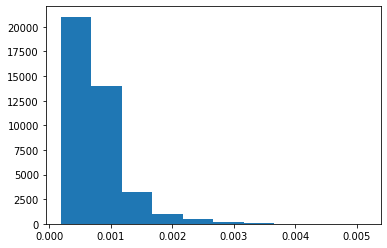

In [ ]:
plt.hist(lst_dist)
plt.show()

In [ ]:
def test(model, iterator, center, alpha):
    model.eval()

    y = []
    lst_dist = []

    with torch.no_grad():
        for (i, batch) in enumerate(iterator):
            src = batch[0].to(device)
            label = batch[2]
            output, _ = model(src, alpha)
            for j in label:
                y.append(int(j))
            lst_dist.extend(get_dist(output, center))
            src.cpu()
    return y, lst_dist

In [ ]:
def get_radius(df, nu=0.05):
    """Optimally solve for radius R via the (1-nu)-quantile of distances."""
    return df.quantile(nu)

In [ ]:
def dist2label(lst_dist, R):
    y = []
    for i in lst_dist:
        if i <= R:
            y.append(0)
        else:
            y.append(1)
    return y

In [ ]:
def get_best_r(model, target_iter, center, ALPHA, steps = 100):
    y, lst_dist = test(model, target_iter, center, ALPHA)
    df = pd.DataFrame()
    df['label'] = y
    df['dist'] = lst_dist 
    print(df.groupby(['label']).describe())
    mean_normal = np.mean(df['dist'].loc[df['label'] == 0])
    mean_abnormal = np.mean(df['dist'].loc[df['label'] == 1])
    step_len = (mean_abnormal - mean_normal)/steps
    best_r = 0
    best_f1 = -1
    R = mean_normal
    for i in range(steps):
        y_pre = dist2label(lst_dist, R)
        f1 = metrics.f1_score(y, y_pre)
        if f1 > best_f1:
            best_r = R
            best_f1 = f1
        R += step_len
    return best_r, best_f1

In [ ]:
set_seed()
X = list(train_normal_s.Embedding)
X_new = []
for i in tqdm(X):
    temp = []
    for j in i:
        temp.extend(j)
    X_new.append(np.array(temp).reshape(WINDOW_SIZE, EMB_DIM))
y_d = list(train_normal_s.target.values)
y = list(train_normal_s.Label.values)
X_source = torch.tensor(X_new,requires_grad=False)
y_d_source = torch.tensor(y_d).reshape(-1, 1).long()
y_source = torch.tensor(y).reshape(-1, 1).long()
source_iter = get_iter(X_source, y_d_source, y_source)
del X_new
del y_d
del y

100%|██████████| 100000/100000 [00:54<00:00, 1845.48it/s]


In [ ]:
y, lst_dist = test(model, source_iter, center, ALPHA)
R_source = np.quantile(np.array(lst_dist),0.75)
print('R_source with 75% quantile:', R_source)

R_source with 75% quantile: 0.0008830925798974931


In [ ]:
# set_seed()
# val_normal_s  = train_normal_s.loc[train_normal_s['target'] == 0].sample(n=int(VAL_ABNORMAL*VAL_RATIO), random_state = 42)
# X = list(val_normal_s.Embedding)
# X.extend(list(val_abnormal_s.Embedding))
# X_new = []
# for i in tqdm(X):
#     temp = []
#     for j in i:
#         temp.extend(j)
#     X_new.append(np.array(temp).reshape(WINDOW_SIZE, EMB_DIM))
# y_d = list(val_normal_s.target.values)
# y_d.extend(list(val_abnormal_s.target.values))
# y = list(val_normal_s.Label.values)
# y.extend(list(val_abnormal_s.Label.values))
# X_source = torch.tensor(X_new,requires_grad=False)
# y_d_source = torch.tensor(y_d).reshape(-1, 1).long()
# y_source = torch.tensor(y).reshape(-1, 1).long()
# source_iter = get_iter(X_source, y_d_source, y_source)
# del X_new
# del y_d
# del y
# R_val, f1_val = get_best_r(model, source_iter, center, ALPHA)
# print('R_source with val :', R_val)
# print('\n AUC:', f1_val)

In [ ]:
set_seed()
X = list(train_normal_t.Embedding)
X_new = []
for i in tqdm(X):
    temp = []
    for j in i:
        temp.extend(j)
    X_new.append(np.array(temp).reshape(WINDOW_SIZE, EMB_DIM))
y_d = list(train_normal_t.target.values)
y = list(train_normal_t.Label.values)
X_target = torch.tensor(X_new,requires_grad=False)
y_d_target = torch.tensor(y_d).reshape(-1, 1).long()
y_target = torch.tensor(y).reshape(-1, 1).long()
target_iter = get_iter(X_target, y_d_target, y_target)
del X_new
del y_d
del y

100%|██████████| 100000/100000 [00:54<00:00, 1850.45it/s]


In [ ]:
y, lst_dist = test(model, target_iter, center, ALPHA)
df = pd.DataFrame()
df['label'] = y
df['dist'] = lst_dist
R_target = np.quantile(np.array(lst_dist),0.75)
print('R_target with 75% quantile:', R_target)

R_target with 75% quantile: 0.0009728902368806303


**Source dataset testing**

In [ ]:
set_seed()
X = list(test_normal_s.Embedding.values[::int(1/TEST_RATIO)])
X.extend(list(test_abnormal_s.Embedding.values[::int(1/TEST_RATIO)]))
X_new = []
for i in tqdm(X):
    temp = []
    for j in i:
        temp.extend(j)
    X_new.append(np.array(temp).reshape(WINDOW_SIZE, EMB_DIM))
y_d = list(test_normal_s.target.values[::int(1/TEST_RATIO)])
y_d.extend(list(test_abnormal_s.target.values[::int(1/TEST_RATIO)]))
y = list(test_normal_s.Label.values[::int(1/TEST_RATIO)])
y.extend(list(test_abnormal_s.Label.values[::int(1/TEST_RATIO)]))
X_test = torch.tensor(X_new, requires_grad=False)
y_d_test = torch.tensor(y_d).reshape(-1,1).long()
y_test = torch.tensor(y).reshape(-1,1).long()
test_iter = get_iter(X_test, y_d_test, y_test)
del X_new
del y_d
del y

100%|██████████| 20304/20304 [00:11<00:00, 1835.77it/s]


In [ ]:
y, lst_dist = test(model, test_iter, center, ALPHA)
df = pd.DataFrame()
df['label'] = y
df['dist'] = lst_dist
R_n = get_radius(df['dist'].loc[df['label'] == 0], 0.50)
R_ab = get_radius(df['dist'].loc[df['label'] == 1], 0.50)
R = (R_n + R_ab)/2
print('R is:', R)
df.groupby('label').describe()

R is: 0.0028558304766193032


dist                      ...                              
         count      mean       std  ...       50%       75%       max
label                               ...                              
0      16559.0  0.000651  0.000430  ...  0.000534  0.000883  0.005223
1       3745.0  0.005099  0.003006  ...  0.005177  0.007185  0.013612

[2 rows x 8 columns]

In [ ]:
y_pre = dist2label(lst_dist, R)
print("Accuracy:",metrics.accuracy_score(y, y_pre))
print(metrics.classification_report(y, y_pre, digits=5))
print(confusion_matrix(y, y_pre))

Accuracy: 0.9239066193853428
              precision    recall  f1-score   support

           0    0.91738   0.99644   0.95528     16559
           1    0.97455   0.60320   0.74518      3745

    accuracy                        0.92391     20304
   macro avg    0.94596   0.79982   0.85023     20304
weighted avg    0.92792   0.92391   0.91652     20304

[[16500    59]
 [ 1486  2259]]


In [ ]:
y_pre = dist2label(lst_dist, R_target)
print("Accuracy:",metrics.accuracy_score(y, y_pre))
print(metrics.classification_report(y, y_pre, digits=5))
print(confusion_matrix(y, y_pre))

Accuracy: 0.8238770685579196
              precision    recall  f1-score   support

           0    0.99286   0.78972   0.87972     16559
           1    0.51185   0.97490   0.67126      3745

    accuracy                        0.82388     20304
   macro avg    0.75235   0.88231   0.77549     20304
weighted avg    0.90414   0.82388   0.84127     20304

[[13077  3482]
 [   94  3651]]


In [ ]:
y_pre = dist2label(lst_dist, R_source)
print("Accuracy:",metrics.accuracy_score(y, y_pre))
print(metrics.classification_report(y, y_pre, digits=5))
print(confusion_matrix(y, y_pre))

Accuracy: 0.7980693459416863
              precision    recall  f1-score   support

           0    0.99350   0.75735   0.85950     16559
           1    0.47689   0.97810   0.64117      3745

    accuracy                        0.79807     20304
   macro avg    0.73520   0.86773   0.75034     20304
weighted avg    0.89822   0.79807   0.81923     20304

[[12541  4018]
 [   82  3663]]


**Target dataset testing**

In [ ]:
set_seed()
X = list(test_normal_t.Embedding.values[::int(1/TEST_RATIO)])
X.extend(list(test_abnormal_t.Embedding.values[::int(1/TEST_RATIO)]))
X_new = []
for i in tqdm(X):
    temp = []
    for j in i:
        temp.extend(j)
    X_new.append(np.array(temp).reshape(WINDOW_SIZE, EMB_DIM))
y_d = list(test_normal_t.target.values[::int(1/TEST_RATIO)])
y_d.extend(list(test_abnormal_t.target.values[::int(1/TEST_RATIO)]))
y = list(test_normal_t.Label.values[::int(1/TEST_RATIO)])
y.extend(list(test_abnormal_t.Label.values[::int(1/TEST_RATIO)]))
X_test = torch.tensor(X_new, requires_grad=False)
y_d_test = torch.tensor(y_d).reshape(-1,1).long()
y_test = torch.tensor(y).reshape(-1,1).long()
test_iter = get_iter(X_test, y_d_test, y_test)

100%|██████████| 92431/92431 [00:50<00:00, 1826.50it/s]


In [ ]:
y, lst_dist = test(model, test_iter, center, ALPHA)

In [ ]:
df = pd.DataFrame()
df['label'] = y
df['dist'] = lst_dist
R_n = get_radius(df['dist'].loc[df['label'] == 0], 0.50)
R_ab = get_radius(df['dist'].loc[df['label'] == 1], 0.50)
R = (R_n + R_ab)/2
print('R is:', R)
df.groupby('label').describe()

R is: 0.0009316116775153205


dist                      ...                              
         count      mean       std  ...       50%       75%       max
label                               ...                              
0      55582.0  0.000867  0.000489  ...  0.000700  0.000977  0.007838
1      36849.0  0.001408  0.000852  ...  0.001163  0.001416  0.004597

[2 rows x 8 columns]

In [ ]:
y_pre = dist2label(lst_dist, R)
print("Accuracy:",metrics.accuracy_score(y, y_pre))
print(metrics.classification_report(y, y_pre, digits=5))
print(confusion_matrix(y, y_pre))

Accuracy: 0.7090370113922818
              precision    recall  f1-score   support

           0    0.78004   0.71885   0.74819     55582
           1    0.62079   0.69424   0.65546     36849

    accuracy                        0.70904     92431
   macro avg    0.70041   0.70654   0.70183     92431
weighted avg    0.71655   0.70904   0.71122     92431

[[39955 15627]
 [11267 25582]]


In [ ]:
y_pre = dist2label(lst_dist, R_target)
print("Accuracy:",metrics.accuracy_score(y, y_pre))
print(metrics.classification_report(y, y_pre, digits=5))
print(confusion_matrix(y, y_pre))

Accuracy: 0.7132888316690288
              precision    recall  f1-score   support

           0    0.76902   0.74781   0.75827     55582
           1    0.63480   0.66121   0.64774     36849

    accuracy                        0.71329     92431
   macro avg    0.70191   0.70451   0.70300     92431
weighted avg    0.71551   0.71329   0.71421     92431

[[41565 14017]
 [12484 24365]]


In [ ]:
y_pre = dist2label(lst_dist, R_source)
print("Accuracy:",metrics.accuracy_score(y, y_pre))
print(metrics.classification_report(y, y_pre, digits=5))
print(confusion_matrix(y, y_pre))

Accuracy: 0.6912399519641679
              precision    recall  f1-score   support

           0    0.78675   0.66746   0.72221     55582
           1    0.59177   0.72710   0.65249     36849

    accuracy                        0.69124     92431
   macro avg    0.68926   0.69728   0.68735     92431
weighted avg    0.70902   0.69124   0.69442     92431

[[37099 18483]
 [10056 26793]]
